# Import

In [2]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
from ast import literal_eval
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

from obspy import read,Stream,Trace
from obspy.signal.trigger import ar_pick, pk_baer

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger, ScreenLogger
from bayes_opt.event import Events

from tune_pk_baer import tune_baer, eval_baer

In [3]:
cm = 1 / 2.54
fts = 8

# Loading data

In [4]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 52864/52864 [00:28<00:00, 1877.26it/s]


In [5]:
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)

In [6]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")
dataset_ENZ = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
dataset_ENZ.filter(dataset_ENZ["split"].isin(["dev", "test"]), inplace=True)
dataset_ENZ.preload_waveforms(pbar=True)

dataset_ENZ_lp_and_noise = dataset_ENZ.filter(
    (dataset_ENZ.metadata["source_type"] == "lp")
    | (dataset_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ENZ_rg_and_noise = dataset_ENZ.filter(
    (dataset_ENZ.metadata["source_type"] != "lp")
    | (dataset_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

Preloading waveforms: 100%|██████████| 52864/52864 [00:08<00:00, 6119.54it/s] 


In [5]:
# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise exists


# Load models

In [7]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [8]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
# vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

['Detection', 'P', 'S']
PSN
peak
peak
cpu
cuda:0


In [9]:
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_eqt2.cuda()
org_pn.cuda()
print("org_eqt")
print(org_eqt.labels)
print(org_eqt.component_order)
print(org_eqt.norm)
print(org_eqt.device)
print()

print("org_pn")
print(org_pn.labels)
print(org_pn.component_order)
print(org_pn.norm)
print(org_pn.device)
print()

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print("int_eqt")
print(eqt_instance.labels)
print(eqt_instance.component_order)
print(eqt_instance.norm)
print(eqt_instance.device)
print()

print("int_pn")
print(pn_instance.labels)
print(pn_instance.component_order)
print(pn_instance.norm)
print(pn_instance.device)
print()

org_eqt
['Detection', 'P', 'S']
ZNE
std
cuda:0

org_pn
NPS
ENZ
std
cuda:0

int_eqt
['Detection', 'P', 'S']
ZNE
peak
cuda:0

int_pn
PSN
ZNE
peak
cuda:0



In [10]:
eqt_stead = sbm.EQTransformer.from_pretrained("stead")
pn_stead = sbm.PhaseNet.from_pretrained("stead")
eqt_stead.cuda()
pn_stead.cuda()
print(eqt_stead.labels)
print(pn_stead.labels)
print(eqt_stead.norm)
print(pn_stead.norm)
print(eqt_stead.device)
print(pn_stead.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


# Evaluation on the test set

Test the retrained model

In [13]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [10]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.22]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/vol_eqt_cpu exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 325765.42it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2200
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/vol_eqt_cpu exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 341564.91it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/vol_eqt_cpu exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 339072.76it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.2200


In [15]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [9]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/vol_pn_cpu exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 331490.17it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3900
Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/vol_pn_cpu exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 345363.86it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/vol_pn_cpu exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 344467.97it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


Test the original model

In [8]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)

In [9]:
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model",  "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,pretraining,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,instance,0.13,0.050
1,EQTransformer_org,EQTransformer,original,0.01,0.001
2,EQTransformer_org_instance,EQTransformer,instance,0.04,0.040
3,PhaseNet_org,PhaseNet,original,0.28,0.170
4,PhaseNet_org_stead,PhaseNet,stead,0.01,0.040
5,EQTransformer_org_stead,EQTransformer,stead,0.02,0.010


In [19]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/35120 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 344267.86it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.001
Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 351043.20it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 345972.16it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.001


Probability threshold: 0.010


In [65]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 354570.80it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2600
Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 341704.99it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 349931.28it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [20]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn_incorrect_component",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.28, 0.17]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 352150.75it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.280
Probability threshold: 0.170
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 344981.58it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.280


Probability threshold: 0.170
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 348373.76it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.280


Probability threshold: 0.170


Deal with the original PhaseNet separately because it uses component order of ENZ

In [11]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset_ENZ, dataset_ENZ_lp_and_noise, dataset_ENZ_rg_and_noise]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 328394.45it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2500
Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 354200.81it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 358452.97it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [21]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 346233.39it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.040
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 351129.62it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.040


/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 318899.55it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.040


In [22]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 352285.50it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.130
Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 348971.63it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.130


Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 356700.76it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


Test the model trained on STEAD dataset

In [23]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = eqt_stead
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"std_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.02, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 336805.61it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.020
Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 350550.39it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.020


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 347677.83it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.020


Probability threshold: 0.010


In [24]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = pn_stead
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"std_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        prob_thres=np.array([0.01, 0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test/all_pred/task0/std_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 357729.24it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.010
Probability threshold: 0.040
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/std_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 350604.43it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.010


Probability threshold: 0.040
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/std_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 356393.76it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.010


Probability threshold: 0.040


Test Pk-Baer

In [25]:
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_baer(
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
    )

100%|██████████| 15057/15057 [00:10<00:00, 1383.40it/s]


## Collect results

In [12]:
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test/")
data_type_dirs = ("lp_and_noise_pred", "rg_and_noise_pred", "all_pred")

In [13]:
eqt_pred_dirs = ("org_eqt_nonconservative", "int_eqt", "vol_eqt")
pn_pred_dirs = ("org_pn", "int_pn", "vol_pn")

In [14]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [30]:
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    # "org_eqt": 0.01,
    "org_eqt_nonconservative": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
    "std_eqt": 0.02,
    "std_pn": 0.01,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    # "org_eqt": 0.001,
    "org_eqt_nonconservative": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
    "std_eqt": 0.01,
    "std_pn": 0.04,
}
print(p_thre_dict)
print(s_thre_dict)

{'vol_eqt': 0.22, 'vol_pn': 0.39, 'org_eqt_nonconservative': 0.26, 'org_pn': 0.25, 'int_eqt': 0.04, 'int_pn': 0.13, 'std_eqt': 0.02, 'std_pn': 0.01}
{'vol_eqt': 0.22, 'vol_pn': 0.34, 'org_eqt_nonconservative': 0.15, 'org_pn': 0.19, 'int_eqt': 0.04, 'int_pn': 0.05, 'std_eqt': 0.01, 'std_pn': 0.04}


### Plot EQTransformer

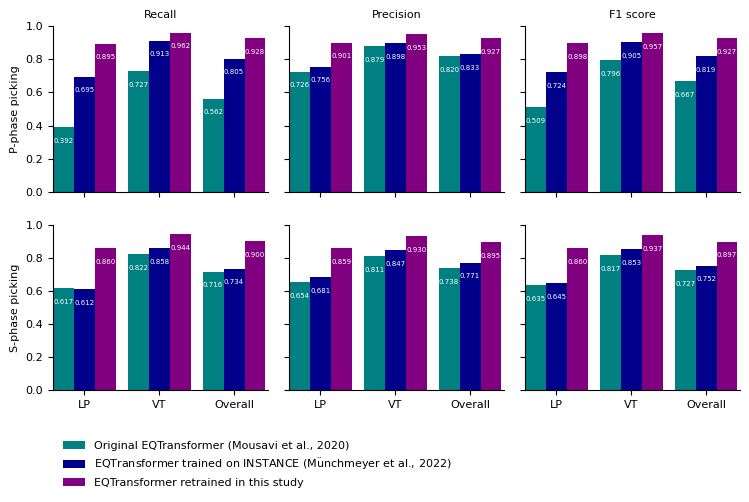

In [378]:
p_metric_dict = {}
s_metric_dict = {}
p_precision_dict = {x: [] for x in eqt_pred_dirs}
s_precision_dict = {x: [] for x in eqt_pred_dirs}
p_recall_dict = {x: [] for x in eqt_pred_dirs}
s_recall_dict = {x: [] for x in eqt_pred_dirs}
p_f1score_dict = {x: [] for x in eqt_pred_dirs}
s_f1score_dict = {x: [] for x in eqt_pred_dirs}
for model_name in eqt_pred_dirs:
    for data_type in data_type_dirs:
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])


p_metrics = {
    "Recall": p_recall_dict,
    "Precision": p_precision_dict,
    "F1 score": p_f1score_dict,
}
s_metrics = {
    "Recall": s_recall_dict,
    "Precision": s_precision_dict,
    "F1 score": s_f1score_dict,
}

#plot
cm = 1 / 2.54
fig, axs = plt.subplots(
    2, 3, figsize=(22.5 * cm, 12 * cm), sharey="all", sharex="all"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.2, wspace=0.1)

data_types = ("LP", "VT", "Overall")
x = np.arange(len(data_types))
# x=np.array([0,1.5,3])
width = 0.28  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = ["teal", "darkblue", "purple"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "vol_eqt": "EQTransformer retrained in this study",
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
}

fts = 8
for i in range(3):
    p_metric_dict = p_metrics[metric_names[i]]
    s_metric_dict = s_metrics[metric_names[i]]
    ax = axs[0][i]

    # multiplier = 0
    fmt = "{:.3f}"
    interval = width
    for k, (attribute, value) in enumerate(p_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(
            x + offset, value, width, label=labels[attribute], color=colors[k]
        )
        ax.bar_label(rects, padding=-12, fmt=fmt, fontsize=fts - 3, color="white")
        ax.spines[["right", "top"]].set_visible(False)
        # ax.set_yscale('log')
        # multiplier += 1
    ax.set_xticks(x + interval, data_types, fontsize=fts)
    ax.set_title(metric_names[i], fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0, 1])

    # S
    ax = axs[1][i]

    # multiplier = 0
    for k, (attribute, value) in enumerate(s_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(
            x + offset, value, width, label=labels[attribute], color=colors[k]
        )
        ax.bar_label(rects, padding=-12, fmt=fmt, fontsize=fts - 3, color="white")
        ax.spines[["right", "top"]].set_visible(False)
        # ax.set_yscale('log')
        # multiplier += 1
    ax.set_xticks(x + interval, data_types, fontsize=fts)
    ax.set_ylim([0, 1])
    ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 2.6 * interval)
    ax.tick_params(labelsize=fts)


# axs[0][0].set_title("P picking")
# axs[0][1].set_title("S picking")
axs[1][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, -0.65, 0.5, 0.1),
    frameon=False,
    fontsize=fts,
    ncols=1,
)
axs[0][0].set_ylabel("P-phase picking", fontsize=fts)
axs[1][0].set_ylabel("S-phase picking", fontsize=fts)
# plt.savefig("perf_comp_eqt.pdf", bbox_inches="tight", pad_inches=0)

### Plot PhaseNet

In [379]:
pn_pred_dirs

('org_pn', 'int_pn', 'vol_pn')

In [380]:
p_metric_dict={}
s_metric_dict={}
p_precision_dict={x:[] for x in pn_pred_dirs}
s_precision_dict={x:[] for x in pn_pred_dirs}
p_recall_dict={x:[] for x in pn_pred_dirs}
s_recall_dict={x:[] for x in pn_pred_dirs}
p_f1score_dict={x:[] for x in pn_pred_dirs}
s_f1score_dict={x:[] for x in pn_pred_dirs}
for model_name in pn_pred_dirs:
    for data_type in data_type_dirs:
        pred_df=pd.read_csv(pred_dir_path/data_type/"task0"/model_name/"test_metrics.csv")
        p_row=pred_df[np.isclose(pred_df["prob_thre"],p_thre_dict[model_name])].iloc[0]
        s_row=pred_df[np.isclose(pred_df["prob_thre"],s_thre_dict[model_name])].iloc[0]
        assert np.abs(p_row["prob_thre"]-p_thre_dict[model_name])<1e-6, f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"]-s_thre_dict[model_name])<1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])

p_metrics={"Recall":p_recall_dict,"Precision":p_precision_dict,"F1 score":p_f1score_dict}
s_metrics={"Recall":s_recall_dict,"Precision":s_precision_dict,"F1 score":s_f1score_dict}

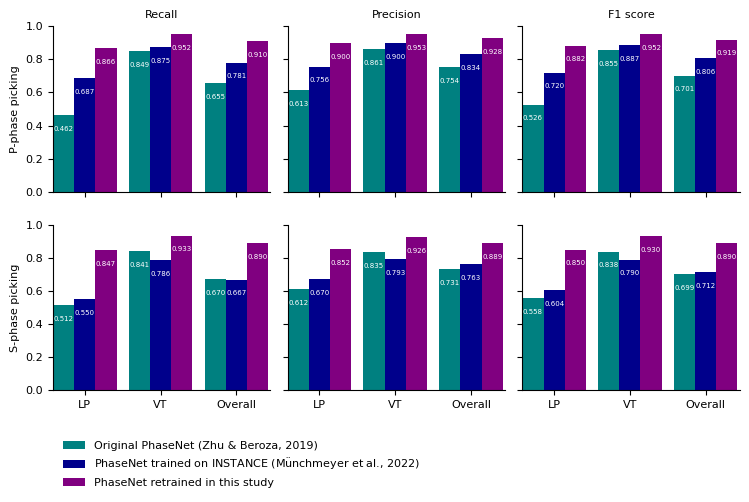

In [381]:
cm = 1/2.54
fig, axs = plt.subplots(2,3,figsize=(22.5*cm,12*cm),sharey="all",sharex="all") #,layout="constrained"
plt.subplots_adjust(hspace=0.2,wspace=0.08)

data_types=("LP","VT","Overall")
x = np.arange(len(data_types))
#x=np.array([0,1.5,3])
width = 0.28  # the width of the bars

metric_names=["Recall","Precision","F1 score"]
colors=["teal","darkblue","purple"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels={"org_eqt":"Original EQTransformer (Mousavi et al., 2020)",
        "int_eqt":r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)","vol_eqt":"EQTransformer retrained in this study",
        "org_pn":"Original PhaseNet (Zhu & Beroza, 2019)",
        "int_pn":r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
        "vol_pn":"PhaseNet retrained in this study",}

fts=8
for i in range(3):
    p_metric_dict=p_metrics[metric_names[i]]
    s_metric_dict=s_metrics[metric_names[i]]
    ax=axs[0][i]

    fmt="{:.3f}"
    interval=width
    for k,(attribute, value) in enumerate(p_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(x + offset, value, width, label=labels[attribute],color=colors[k])
        ax.bar_label(rects, padding=-12,fmt=fmt,fontsize=fts-3,color="white")
        ax.spines[['right', 'top']].set_visible(False)

    ax.set_xticks(x + interval, data_types,fontsize=fts)
    ax.set_title(metric_names[i],fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0,1])
    
    
    # S
    ax=axs[1][i]

    # multiplier = 0
    for k,(attribute, value) in enumerate(s_metric_dict.items()):
        offset = interval* k
        rects = ax.bar(x + offset, value, width, label=labels[attribute],color=colors[k])
        ax.bar_label(rects, padding=-12,fmt=fmt,fontsize=fts-3,color="white")
        ax.spines[['right', 'top']].set_visible(False)

    ax.set_xticks(x + interval, data_types,fontsize=fts)
    ax.set_ylim([0,1])
    ax.set_xlim(x[0]-0.5*interval,x[-1]+2.6*interval)
    ax.tick_params(labelsize=fts)

axs[1][0].legend(loc='lower left',  bbox_to_anchor=(0.0, -0.65, 0.5, 0.1),frameon=False,fontsize=fts, ncols=1)
axs[0][0].set_ylabel("P-phase picking",fontsize=fts)
axs[1][0].set_ylabel("S-phase picking",fontsize=fts)
# plt.savefig("perf_comp_pn.pdf",bbox_inches="tight",pad_inches=0)

### Plot EQTransformer and PhaseNet together

In [18]:
# pred_dirs=pn_pred_dirs+eqt_pred_dirs
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]

In [19]:
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

In [20]:
metrics["F1 score"]

[{'org_pn': [0.854659132702531, 0.8378378378378378],
  'org_eqt': [0.7959287531806617, 0.8165418894830659],
  'int_pn': [0.8872732168703086, 0.7895533141210374],
  'int_eqt': [0.9053844887205664, 0.8527231251782149],
  'vol_pn': [0.9523872811243644, 0.92985842985843],
  'vol_eqt': [0.9571711830799736, 0.9373508565729955]},
 {'org_pn': [0.5264193048148569, 0.5578374319504412],
  'org_eqt': [0.5092146055804341, 0.6348079244479159],
  'int_pn': [0.7200639377302105, 0.6041950628502196],
  'int_eqt': [0.7243512215349528, 0.6445590585500509],
  'vol_pn': [0.8823628806055897, 0.8497007852225952],
  'vol_eqt': [0.8979510377860564, 0.8597035504998276]}]

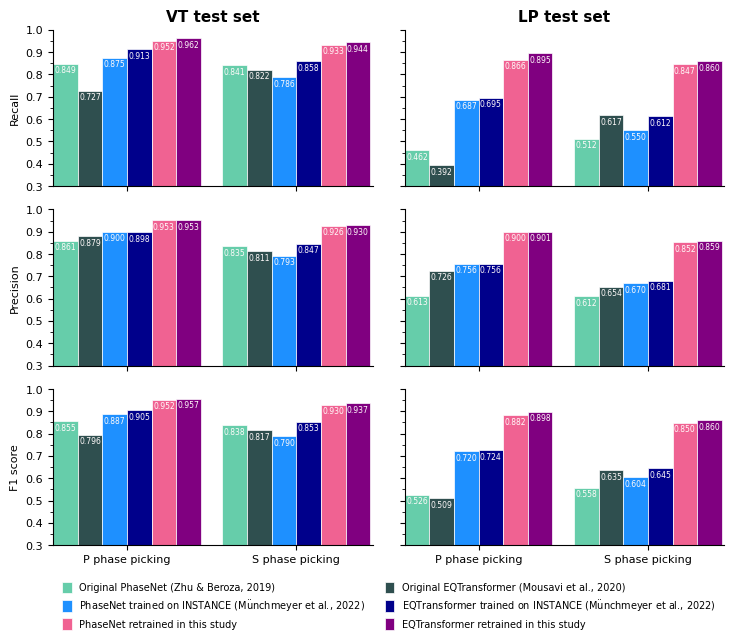

In [14]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 17 * cm), sharey="all", sharex="all"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.1)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.2
# x=np.array([0,1.5,3])
width = 0.32  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = [
    "mediumaquamarine",
    "darkslategrey",
    "dodgerblue",
    "darkblue",
    "#F06292",
    "purple",
]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}

fts = 8
for i in range(3):
    for j in range(2):
        metric_dict = metrics[metric_names[i]][j]

        ax = axs[i][j]

        fmt = "{:.3f}"
        interval = width
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                edgecolor="white",
                color=colors[k],
                linewidth=0.5,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=-8, fmt=fmt, fontsize=fts - 2.5, color="snow")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.3, 1])
        ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    axs[i][0].set_ylabel(metric_names[i], fontsize=fts)

handles, legend_labels = axs[-1][0].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]
#
leg = axs[-1][0].legend(
    [handles[idx] for idx in legend_label_order],
    [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.0,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.0, -0.6, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncols=2,
    # columnspacing=0.8,
)

axs[0][0].set_title("VT test set", fontsize=fts + 3, weight="bold")
axs[0][1].set_title("LP test set", fontsize=fts + 3, weight="bold")
# plt.savefig("perf_comp_pn_eqt.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

Only F1 score

In [85]:
pred_dir_path_list = [
    Path("/home/zhongyiyuan/volpick/model_training/Test/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/"),
]

metrics_list = []
for i, pred_dir_path in enumerate(pred_dir_path_list):
    if i == 0:
        data_types_plotted = ["lp_and_noise_pred", "rg_and_noise_pred"]
    elif i == 1:
        data_types_plotted = [
            "ncedc_lp_pred",
            "ncedc_vt_pred",
        ]
    else:
        data_types_plotted = ["japan_tec_lp_pred"]

    precision_dict = [
        {x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))
    ]
    recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
    f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

    for model_name in pred_dirs:
        for j, data_type in enumerate(data_types_plotted):
            pred_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
            )
            p_row = pred_df[
                np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])
            ].iloc[0]
            s_row = pred_df[
                np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])
            ].iloc[0]
            assert (
                np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
            ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
            assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

            precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
            recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
            f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]
    metrics = {
        "Recall": recall_dict,
        "Precision": precision_dict,
        "F1 score": f1score_dict,
    }
    metrics_list.append(metrics)

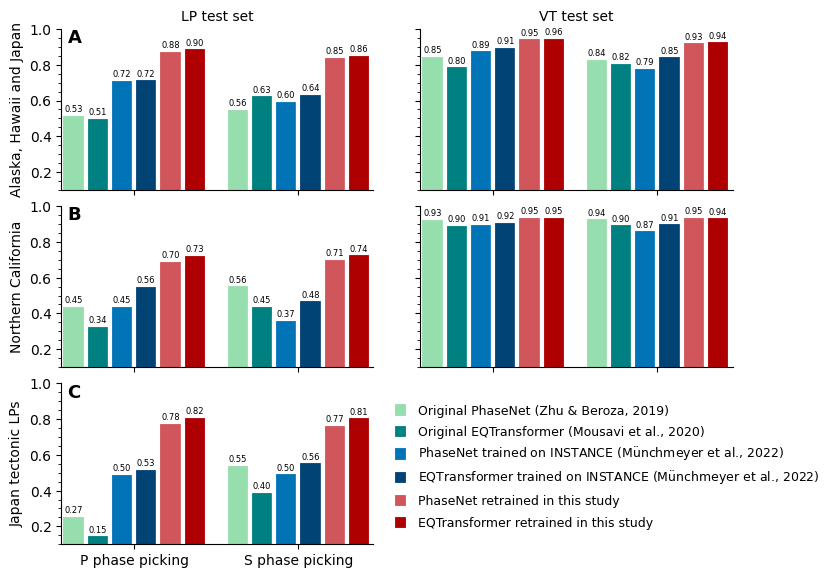

In [379]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 17 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.1, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.2
# x=np.array([0,1.5,3])
width = 0.325  # the width of the bars

metric_names = ["F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Northern California",
    "Japan tectonic LFEs",
]

fts = 10
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"
        interval = width
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                edgecolor="white",
                color=colors[k],
                linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=0, fmt=fmt, fontsize=fts - 4.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.1, 1])
        ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        chr(65 + i),
        verticalalignment="top",
        horizontalalignment="left",
        weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.2,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.125, -1.08, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
)

axs[0][1].set_title("VT test set", fontsize=fts)
axs[0][0].set_title("LP test set", fontsize=fts)
# plt.savefig(
#     "f1_scores_3_testsets_for_poster.pdf", dpi=600, bbox_inches="tight", pad_inches=0
# )

### Plot residuals

In [10]:
# pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
eqt_pred_dirs = ("org_eqt_nonconservative", "int_eqt", "vol_eqt")
pn_pred_dirs = ("org_pn", "int_pn", "vol_pn")
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test/")

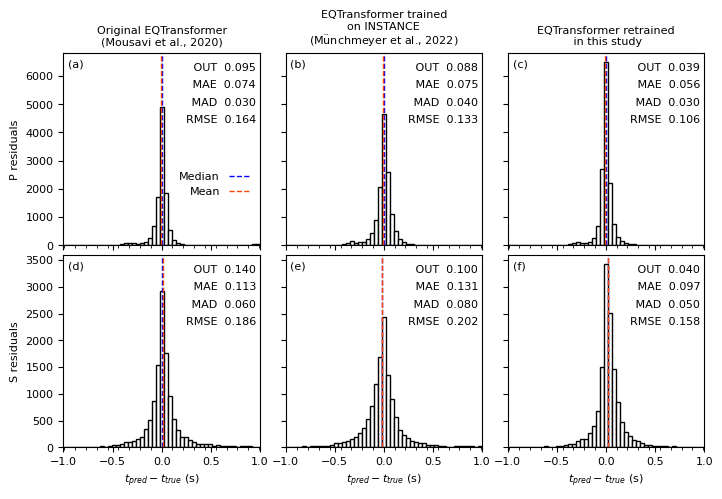

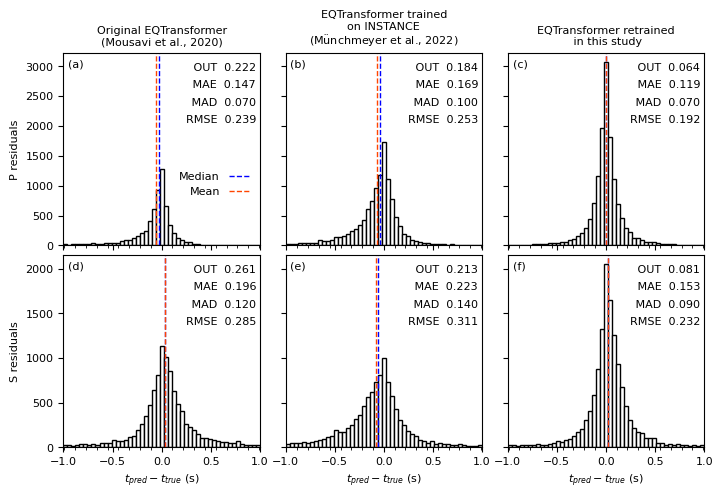

In [557]:
# eqt
def str2intlist(x):
    return np.array([int(y) for y in x.strip("[]").split()])


cm = 1 / 2.54
fts = 8
figsize = (21 * cm, 13 * cm)
fig1, axs1 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.05, wspace=0.13)
fig2, axs2 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
thre_dict = {"p": p_thre_dict, "s": s_thre_dict}
axs_list = [axs1, axs2]
plt.subplots_adjust(hspace=0.05, wspace=0.13)
labels = {
    "org_eqt": "Original EQTransformer\n(Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained\non INSTANCE\n"
    + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained\n in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained\non INSTANCE\n" + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained\n in this study",
}
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]
for j, data_type in enumerate(data_types_plotted):
    axs = axs_list[j]
    for i, model_name in enumerate(eqt_pred_dirs):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_task0.csv",
            converters={
                f"p_pred_sample_thr{p_thre_dict[model_name]:.3f}": str2intlist,
                f"s_pred_sample_thr{s_thre_dict[model_name]:.3f}": str2intlist,
            },
        )
        for k, phase in enumerate(["p", "s"]):
            ax = axs[k][i]
            idxs_ground_truth = pred_df.apply(
                lambda x: np.array([x[f"trace_{phase}_arrival_sample"]])
                if pd.notna(x[f"trace_{phase}_arrival_sample"])
                and (x[f"trace_{phase}_arrival_sample"] >= x["start_sample"])
                and (x[f"trace_{phase}_arrival_sample"] < x["end_sample"])
                else np.array([]),
                axis=1,
            ).tolist()

            idxs_predicted = pred_df[
                f"{phase}_pred_sample_thr{thre_dict[phase][model_name]:.3f}"
            ].tolist()

            residuals = compute_residuals(
                idxs_ground_truth,
                idxs_predicted,
                sampling_rate=100,
                method=0,
            )

            bound = 1
            bins = np.linspace(-bound, bound, 50)
            ax.hist(
                residuals,
                bins=bins,
                color="white",
                edgecolor="black",
            )

            outlier = residuals[(residuals < -bound) | (residuals > bound)].copy()
            out = outlier.size / residuals.size

            inwindow_residuals = residuals.copy()
            inwindow_residuals = inwindow_residuals[
                (inwindow_residuals > -bound) & (inwindow_residuals < bound)
            ]
            mean2 = np.mean(inwindow_residuals)
            median2 = np.median(inwindow_residuals)
            std2 = np.std(inwindow_residuals, ddof=1)
            rmse2 = np.sqrt(np.mean(inwindow_residuals**2))
            mae2 = np.mean(np.abs(inwindow_residuals))

            mad2 = np.median(np.abs(inwindow_residuals - np.median(inwindow_residuals)))
            ax.axvline(x=median2, ls="--", linewidth=1, color="blue", label="Median")
            ax.axvline(x=mean2, ls="--", linewidth=1, color="orangered", label="Mean")

            metric_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
            )
            row = metric_df[
                np.isclose(metric_df["prob_thre"], thre_dict[phase][model_name])
            ].iloc[0]
            assert np.isclose(row[f"{phase}_out"], out)
            assert np.isclose(row[f"{phase}_modified_MAE2"], mae2)
            assert np.isclose(row[f"{phase}_modified_MAD2"], mad2)
            assert np.isclose(row[f"{phase}_modified_RMSE2"], rmse2)

            text_y = 0.95
            for stat_name, stat in {
                "OUT": out,
                "MAE": mae2,
                "MAD": mad2,
                "RMSE": rmse2,
            }.items():
                ax.text(
                    0.98,
                    text_y,
                    f"""{stat_name:>6}{stat:>7.3f}""",
                    verticalalignment="top",
                    horizontalalignment="right",
                    transform=ax.transAxes,
                    fontsize=fts,
                )
                text_y -= 0.09
            ax.set_xlim([-bound, bound])
            ax.tick_params(labelsize=fts)
            if k == 0:
                # ax.set_ylabel(labels[model_name], fontsize=fts)
                ax.set_title(labels[model_name], fontsize=fts)

    axs[-1][0].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][1].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][2].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.11))

    # axs[0][0].set_title("P residuals", fontsize=fts)
    # axs[0][1].set_title("S residuals", fontsize=fts)
    axs[0][0].set_ylabel("P residuals", fontsize=fts)
    axs[1][0].set_ylabel("S residuals", fontsize=fts)
    for i_ax, ax in enumerate(axs.flat):
        ax.text(
            0.025,
            0.97,
            "(" + chr(97 + i_ax) + ")",
            verticalalignment="top",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            # color="black",
        )
    axs[0][0].legend(
        markerfirst=False,
        handlelength=1.9,
        #   markerscale=2,
        loc="lower right",
        bbox_to_anchor=(0.5, 0.2, 0.5, 0.3),
        frameon=False,
        fontsize=fts,
        # ncols=2,
    )
# fig1.savefig("residuals_eqt_VT.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
# fig2.savefig("residuals_eqt_LP.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

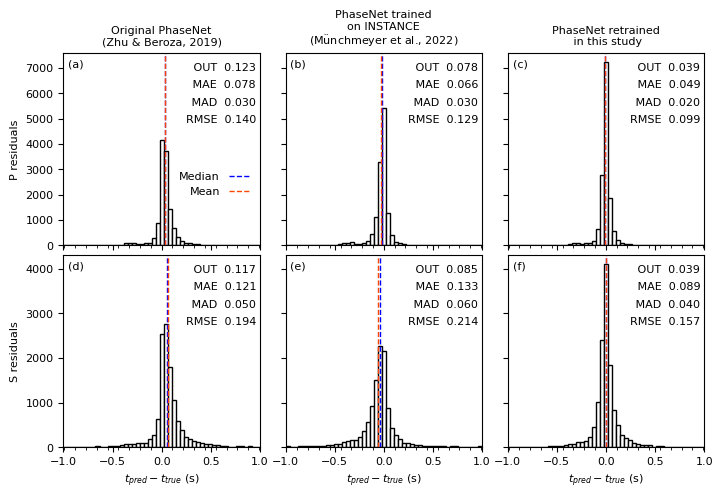

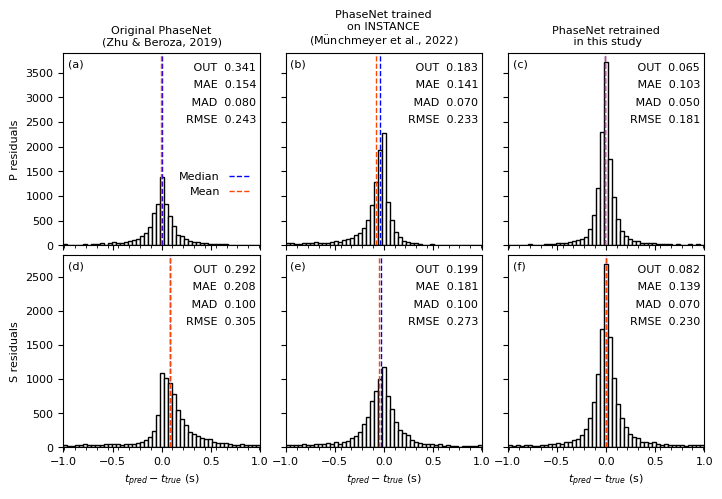

In [358]:
# eqt
def str2intlist(x):
    return np.array([int(y) for y in x.strip("[]").split()])


cm = 1 / 2.54
fts = 8
figsize = (21 * cm, 13 * cm)
fig1, axs1 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.05, wspace=0.13)
fig2, axs2 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
thre_dict = {"p": p_thre_dict, "s": s_thre_dict}
axs_list = [axs1, axs2]
plt.subplots_adjust(hspace=0.05, wspace=0.13)
labels = {
    "org_eqt": "Original EQTransformer\n(Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained\non INSTANCE\n"
    + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained\n in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained\non INSTANCE\n" + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained\n in this study",
}
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]
for j, data_type in enumerate(data_types_plotted):
    axs = axs_list[j]
    for i, model_name in enumerate(pn_pred_dirs):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_task0.csv",
            converters={
                f"p_pred_sample_thr{p_thre_dict[model_name]:.3f}": str2intlist,
                f"s_pred_sample_thr{s_thre_dict[model_name]:.3f}": str2intlist,
            },
        )
        for k, phase in enumerate(["p", "s"]):
            ax = axs[k][i]
            idxs_ground_truth = pred_df.apply(
                lambda x: np.array([x[f"trace_{phase}_arrival_sample"]])
                if pd.notna(x[f"trace_{phase}_arrival_sample"])
                and (x[f"trace_{phase}_arrival_sample"] >= x["start_sample"])
                and (x[f"trace_{phase}_arrival_sample"] < x["end_sample"])
                else np.array([]),
                axis=1,
            ).tolist()

            idxs_predicted = pred_df[
                f"{phase}_pred_sample_thr{thre_dict[phase][model_name]:.3f}"
            ].tolist()

            residuals = compute_residuals(
                idxs_ground_truth,
                idxs_predicted,
                sampling_rate=100,
                method=0,
            )

            bound = 1
            bins = np.linspace(-bound, bound, 50)
            ax.hist(
                residuals,
                bins=bins,
                color="white",
                edgecolor="black",
            )

            outlier = residuals[(residuals < -bound) | (residuals > bound)].copy()
            out = outlier.size / residuals.size

            inwindow_residuals = residuals.copy()
            inwindow_residuals = inwindow_residuals[
                (inwindow_residuals > -bound) & (inwindow_residuals < bound)
            ]
            mean2 = np.mean(inwindow_residuals)
            median2 = np.median(inwindow_residuals)
            std2 = np.std(inwindow_residuals, ddof=1)
            rmse2 = np.sqrt(np.mean(inwindow_residuals**2))
            mae2 = np.mean(np.abs(inwindow_residuals))

            mad2 = np.median(np.abs(inwindow_residuals - np.median(inwindow_residuals)))
            ax.axvline(x=median2, ls="--", linewidth=1, color="blue", label="Median")
            ax.axvline(x=mean2, ls="--", linewidth=1, color="orangered", label="Mean")

            metric_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
            )
            row = metric_df[
                np.isclose(metric_df["prob_thre"], thre_dict[phase][model_name])
            ].iloc[0]
            assert np.isclose(row[f"{phase}_out"], out)
            assert np.isclose(row[f"{phase}_modified_MAE2"], mae2)
            assert np.isclose(row[f"{phase}_modified_MAD2"], mad2)
            assert np.isclose(row[f"{phase}_modified_RMSE2"], rmse2)

            text_y = 0.95
            for stat_name, stat in {
                "OUT": out,
                "MAE": mae2,
                "MAD": mad2,
                "RMSE": rmse2,
            }.items():
                ax.text(
                    0.98,
                    text_y,
                    f"""{stat_name:>6}{stat:>7.3f}""",
                    verticalalignment="top",
                    horizontalalignment="right",
                    transform=ax.transAxes,
                    fontsize=fts,
                )
                text_y -= 0.09
            ax.set_xlim([-bound, bound])
            ax.tick_params(labelsize=fts)
            if k == 0:
                # ax.set_ylabel(labels[model_name], fontsize=fts)
                ax.set_title(labels[model_name], fontsize=fts)

    axs[-1][0].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][1].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][2].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.11))

    # axs[0][0].set_title("P residuals", fontsize=fts)
    # axs[0][1].set_title("S residuals", fontsize=fts)
    axs[0][0].set_ylabel("P residuals", fontsize=fts)
    axs[1][0].set_ylabel("S residuals", fontsize=fts)
    for i_ax, ax in enumerate(axs.flat):
        ax.text(
            0.025,
            0.97,
            "(" + chr(97 + i_ax) + ")",
            verticalalignment="top",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            # color="black",
        )
    axs[0][0].legend(
        markerfirst=False,
        handlelength=1.9,
        #   markerscale=2,
        loc="lower right",
        bbox_to_anchor=(0.5, 0.2, 0.5, 0.3),
        frameon=False,
        fontsize=fts,
        # ncols=2,
    )
# fig1.savefig("residuals_pn_VT.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
# fig2.savefig("residuals_pn_LP.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

In [23]:
test_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_eqt_nonconservative/test_task0.csv"
)

/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_eqt_nonconservative/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_eqt_nonconservative/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_pn/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task0/org_pn/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_eqt_nonconservative/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_eqt_nonconservative/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_pn/test_task0.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task0/org_pn/test_task0.csv


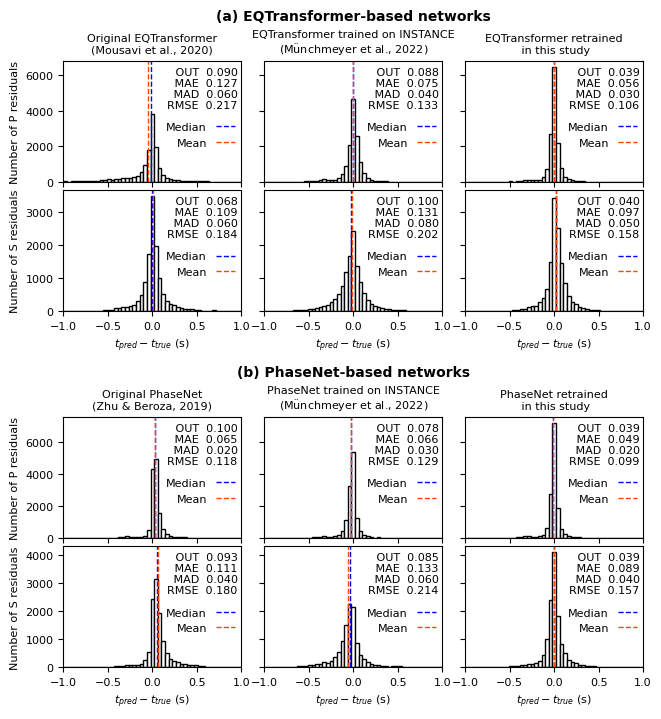

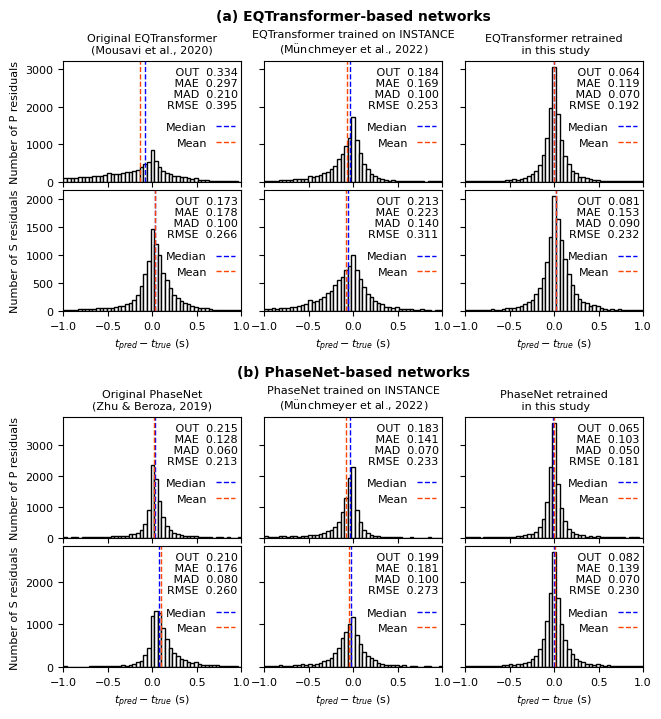

In [11]:
def str2intlist(x):
    return np.array([int(y) for y in x.strip("[]").split()])


cm = 1 / 2.54
fts = 8
figsize = (19 * cm, 20.0 * cm)
fig1, axs1 = plt.subplots(
    5, 3, figsize=figsize, sharex="all", sharey="row", height_ratios=[3, 3, 2.2, 3, 3]
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.075, wspace=0.13)
fig2, axs2 = plt.subplots(
    5, 3, figsize=figsize, sharex="all", sharey="row", height_ratios=[3, 3, 2.2, 3, 3]
)  # ,layout="constrained"
thre_dict = {"p": p_thre_dict, "s": s_thre_dict}
axs_list = [axs1, axs2]
plt.subplots_adjust(hspace=0.075, wspace=0.13)
labels = {
    # "org_eqt": "Original EQTransformer\n(Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer\n(Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained on INSTANCE\n"
    + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained\n in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained on INSTANCE\n" + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained\n in this study",
}
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]
for j, data_type in enumerate(data_types_plotted):
    axs = axs_list[j]
    for i2, output_pred_dirs in enumerate([eqt_pred_dirs, pn_pred_dirs]):
        for i, model_name in enumerate(output_pred_dirs):
            pred_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_task0.csv",
                converters={
                    f"p_pred_sample_thr{p_thre_dict[model_name]:.3f}": str2intlist,
                    f"s_pred_sample_thr{s_thre_dict[model_name]:.3f}": str2intlist,
                    f"p_pred_sample_thr{p_thre_dict[model_name]:.4f}": str2intlist,
                    f"s_pred_sample_thr{s_thre_dict[model_name]:.4f}": str2intlist,
                },
            )
            for k, phase in enumerate(["p", "s"]):
                ax = axs[k + i2 * 3][i]
                idxs_ground_truth = pred_df.apply(
                    lambda x: (
                        np.array([x[f"trace_{phase}_arrival_sample"]])
                        if pd.notna(x[f"trace_{phase}_arrival_sample"])
                        and (x[f"trace_{phase}_arrival_sample"] >= x["start_sample"])
                        and (x[f"trace_{phase}_arrival_sample"] < x["end_sample"])
                        else np.array([])
                    ),
                    axis=1,
                ).tolist()

                try:
                    idxs_predicted = pred_df[
                        f"{phase}_pred_sample_thr{thre_dict[phase][model_name]:.3f}"
                    ].tolist()
                except KeyError as e:
                    print(
                        pred_dir_path
                        / data_type
                        / "task0"
                        / model_name
                        / "test_task0.csv"
                    )
                    idxs_predicted = pred_df[
                        f"{phase}_pred_sample_thr{thre_dict[phase][model_name]:.4f}"
                    ].tolist()

                residuals = compute_residuals(
                    idxs_ground_truth,
                    idxs_predicted,
                    sampling_rate=100,
                    method=0,
                )

                bound = 1
                bins = np.linspace(-bound, bound, 50)
                ax.hist(
                    residuals,
                    bins=bins,
                    color="white",
                    edgecolor="black",
                )

                outlier = residuals[(residuals < -bound) | (residuals > bound)].copy()
                out = outlier.size / residuals.size

                inwindow_residuals = residuals.copy()
                inwindow_residuals = inwindow_residuals[
                    (inwindow_residuals > -bound) & (inwindow_residuals < bound)
                ]
                mean2 = np.mean(inwindow_residuals)
                median2 = np.median(inwindow_residuals)
                std2 = np.std(inwindow_residuals, ddof=1)
                rmse2 = np.sqrt(np.mean(inwindow_residuals**2))
                mae2 = np.mean(np.abs(inwindow_residuals))

                mad2 = np.median(
                    np.abs(inwindow_residuals - np.median(inwindow_residuals))
                )
                ax.axvline(
                    x=median2, ls="--", linewidth=1, color="blue", label="Median"
                )
                ax.axvline(
                    x=mean2, ls="--", linewidth=1, color="orangered", label="Mean"
                )

                metric_df = pd.read_csv(
                    pred_dir_path
                    / data_type
                    / "task0"
                    / model_name
                    / "test_metrics.csv"
                )
                row = metric_df[
                    np.isclose(metric_df["prob_thre"], thre_dict[phase][model_name])
                ].iloc[0]
                assert np.isclose(row[f"{phase}_out"], out)
                assert np.isclose(row[f"{phase}_modified_MAE2"], mae2)
                assert np.isclose(row[f"{phase}_modified_MAD2"], mad2)
                assert np.isclose(row[f"{phase}_modified_RMSE2"], rmse2)

                text_y = 0.95
                for stat_name, stat in {
                    "OUT": out,
                    "MAE": mae2,
                    "MAD": mad2,
                    "RMSE": rmse2,
                }.items():
                    ax.text(
                        0.98,
                        text_y,
                        f"""{stat_name:>6}{stat:>7.3f}""",
                        verticalalignment="top",
                        horizontalalignment="right",
                        transform=ax.transAxes,
                        fontsize=fts,
                    )
                    text_y -= 0.09
                ax.set_xlim([-bound, bound])
                ax.tick_params(labelsize=fts)
                if k == 0:
                    # ax.set_ylabel(labels[model_name], fontsize=fts)
                    ax.set_title(labels[model_name], fontsize=fts)
                ax.legend(
                    markerfirst=False,
                    handlelength=1.7,
                    #   markerscale=2,
                    loc="lower right",
                    bbox_to_anchor=(0.52, 0.2, 0.5, 0.3),
                    frameon=False,
                    fontsize=fts,
                    # ncols=2,
                )
    for i in range(3):
        axs[1][i].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
        axs[-1][i].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
        axs[1][i].xaxis.set_tick_params(which="both", labelbottom=True)
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    # axs[0][0].set_title("P residuals", fontsize=fts)
    # axs[0][1].set_title("S residuals", fontsize=fts)
    axs[0][0].set_ylabel("Number of P residuals", fontsize=fts)
    axs[1][0].set_ylabel("Number of S residuals", fontsize=fts)
    axs[3][0].set_ylabel("Number of P residuals", fontsize=fts)
    axs[4][0].set_ylabel("Number of S residuals", fontsize=fts)

    axs[0][1].text(
        0.5,
        1.43,
        "(a) EQTransformer-based networks",
        verticalalignment="top",
        horizontalalignment="center",
        transform=axs[0][1].transAxes,
        fontsize=fts + 2,
        weight="bold",
        # color="black",
    )
    axs[3][1].text(
        0.5,
        1.43,
        "(b) PhaseNet-based networks",
        verticalalignment="top",
        horizontalalignment="center",
        transform=axs[3][1].transAxes,
        fontsize=fts + 2,
        weight="bold",
        # color="black",
    )
    axs[2][0].remove()
    axs[2][1].remove()
    axs[2][2].remove()
fig1.savefig("residuals_eqt_pn_VT.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
fig1.savefig("residuals_eqt_pn_VT.jpg", dpi=600, bbox_inches="tight", pad_inches=0)

fig2.savefig("residuals_eqt_pn_LP.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
fig2.savefig("residuals_eqt_pn_LP.jpg", dpi=600, bbox_inches="tight", pad_inches=0)

In [27]:
p_thre_dict

{'vol_eqt': 0.22,
 'vol_pn': 0.39,
 'org_eqt': 0.01,
 'org_eqt_nonconservative': 0.26,
 'org_pn': 0.25,
 'int_eqt': 0.04,
 'int_pn': 0.13,
 'std_eqt': 0.02,
 'std_pn': 0.01}

# Cross-domain test: NCEDC

In [33]:
data_path_ncedc = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc")

dataset_ncedc = sbd.WaveformDataset(
    data_path_ncedc,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_ncedc))
dataset_ncedc._metadata["split"] = "test"

9682


In [68]:
dataset_ncedc_lp = dataset_ncedc.filter(
    (dataset_ncedc.metadata["source_type"] == "lp")
    | (dataset_ncedc.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ncedc_vt = dataset_ncedc.filter(
    (dataset_ncedc.metadata["source_type"] != "lp")
    | (dataset_ncedc.metadata["source_type"] == "noise"),
    inplace=False,
)

In [67]:
data_path_ncedc = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc")

dataset_ncedc_ENZ = sbd.WaveformDataset(
    data_path_ncedc,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_ncedc_ENZ))
dataset_ncedc_ENZ._metadata["split"] = "test"
dataset_ncedc_ENZ_lp = dataset_ncedc_ENZ.filter(
    (dataset_ncedc_ENZ.metadata["source_type"] == "lp")
    | (dataset_ncedc_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ncedc_ENZ_vt = dataset_ncedc_ENZ.filter(
    (dataset_ncedc_ENZ.metadata["source_type"] != "lp")
    | (dataset_ncedc_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

9682


In [74]:
targets_path_lp_and_rg_ncedc = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc"
)
try:
    targets_path_lp_and_rg_ncedc.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_ncedc} exists")

targets_path_lp_ncedc = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_lp"
)
try:
    targets_path_lp_ncedc.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_ncedc} exists")

targets_path_rg_ncedc = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_vt"
)
try:
    targets_path_rg_ncedc.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_ncedc} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_vt exists


In [394]:
replace_if_exist=False
generate_task0(dataset=dataset_ncedc, output=targets_path_lp_and_rg_ncedc, sampling_rate=100, noise_before_events=False, keep_source_type=True, replace_if_exist=replace_if_exist)
generate_task1(dataset=dataset_ncedc, output=targets_path_lp_and_rg_ncedc, sampling_rate=100, noise_before_events=False, replace_if_exist=replace_if_exist)
generate_task23(dataset=dataset_ncedc, output=targets_path_lp_and_rg_ncedc, sampling_rate=100, replace_if_exist=replace_if_exist)

  0%|          | 0/9682 [00:00<?, ?it/s]

100%|██████████| 9682/9682 [00:03<00:00, 3000.08it/s]


In [395]:
replace_if_exist=False
generate_task0(dataset=dataset_ncedc_lp, output=targets_path_lp_ncedc, sampling_rate=100, noise_before_events=False,keep_source_type=True, replace_if_exist=replace_if_exist)
generate_task1(dataset=dataset_ncedc_lp, output=targets_path_lp_ncedc, sampling_rate=100, noise_before_events=False,replace_if_exist=replace_if_exist)
generate_task23(dataset=dataset_ncedc_lp, output=targets_path_lp_ncedc, sampling_rate=100,replace_if_exist=replace_if_exist)

  0%|          | 0/4841 [00:00<?, ?it/s]

100%|██████████| 4841/4841 [00:01<00:00, 2878.47it/s]


In [396]:
replace_if_exist=False
generate_task0(dataset=dataset_ncedc_vt, output=targets_path_rg_ncedc, sampling_rate=100, noise_before_events=False,keep_source_type=True, replace_if_exist=replace_if_exist)
generate_task1(dataset=dataset_ncedc_vt, output=targets_path_rg_ncedc, sampling_rate=100, noise_before_events=False,replace_if_exist=replace_if_exist)
generate_task23(dataset=dataset_ncedc_vt, output=targets_path_rg_ncedc, sampling_rate=100,replace_if_exist=replace_if_exist)

  0%|          | 0/4841 [00:00<?, ?it/s]

100%|██████████| 4841/4841 [00:01<00:00, 3106.81it/s]


Test the retrained model

In [398]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [397]:
tp_thre=0.5
target_path_list=[targets_path_lp_and_rg_ncedc, targets_path_lp_ncedc, targets_path_rg_ncedc]
dataset_list=[dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model=vol_eqt
for target_i, dataset_i in zip(target_path_list,dataset_list):
    eval_task0(dev_test_set=dataset_i,
                model=model, 
                exp_name=f"vol_eqt",
                targets_path=target_i,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
                prob_thres=np.array([0.22]),
                num_workers=16,
                batchsize=1024,
                num_test_run=-1,
                output_remark="pred",
                tp_thre=tp_thre,
                sets=["test"],
                # sets=["train", "dev","test"],
                # append_to_file=True,
                data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:00<00:00, 346235.35it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.220


/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 349615.61it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.220


/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 261714.88it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.220


In [399]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [400]:
tp_thre=0.5
target_path_list=[targets_path_lp_and_rg_ncedc, targets_path_lp_ncedc, targets_path_rg_ncedc]
dataset_list=[dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model=vol_pn
for target_i, dataset_i in zip(target_path_list,dataset_list):
    eval_task0(dev_test_set=dataset_i,
                model=model, 
                exp_name=f"vol_pn",
                targets_path=target_i,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
                prob_thres=np.array([0.39,0.34]),
                num_workers=16,
                batchsize=1024,
                num_test_run=-1,
                output_remark="pred",
                tp_thre=tp_thre,
                sets=["test"],
                # sets=["train", "dev","test"],
                # append_to_file=True,
                data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:00<00:00, 348188.73it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 349477.21it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 349230.76it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340


Test the original model

In [26]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [402]:
tp_thre=0.5
target_path_list=[targets_path_lp_and_rg_ncedc, targets_path_lp_ncedc, targets_path_rg_ncedc]
dataset_list=[dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model=org_eqt
for target_i, dataset_i in zip(target_path_list,dataset_list):
    eval_task0(dev_test_set=dataset_i,
                model=model, 
                exp_name=f"org_eqt",
                targets_path=target_i,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
                prob_thres=np.array([0.001,0.01]),
                num_workers=16,
                batchsize=1024,
                num_test_run=-1,
                output_remark="pred",
                tp_thre=tp_thre,
                sets=["test"],
                # sets=["train", "dev","test"],
                # append_to_file=True,
                data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:00<00:00, 343171.94it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 361800.85it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 358967.29it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010


In [75]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:16<00:00, 603.56it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5789.41it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 6258.11it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [14]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
# dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]
dataset_list = [dataset_ncedc_ENZ, dataset_ncedc_ENZ_lp, dataset_ncedc_ENZ_vt]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/org_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:16<00:00, 601.47it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5341.18it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5755.44it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [404]:
tp_thre=0.5
target_path_list=[targets_path_lp_and_rg_ncedc, targets_path_lp_ncedc, targets_path_rg_ncedc]
dataset_list=[dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model=eqt_instance
for target_i, dataset_i in zip(target_path_list,dataset_list):
    eval_task0(dev_test_set=dataset_i,
                model=model, 
                exp_name=f"int_eqt",
                targets_path=target_i,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
                prob_thres=np.array([0.04]),
                num_workers=16,
                batchsize=1024,
                num_test_run=-1,
                output_remark="pred",
                tp_thre=tp_thre,
                sets=["test"],
                # sets=["train", "dev","test"],
                # append_to_file=True,
                data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:00<00:00, 354433.79it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.040


/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 364202.00it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.040


/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 357148.84it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.040


In [405]:
tp_thre=0.5
target_path_list=[targets_path_lp_and_rg_ncedc, targets_path_lp_ncedc, targets_path_rg_ncedc]
dataset_list=[dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model=pn_instance
for target_i, dataset_i in zip(target_path_list,dataset_list):
    eval_task0(dev_test_set=dataset_i,
                model=model, 
                exp_name=f"int_pn",
                targets_path=target_i,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
                prob_thres=np.array([0.13,0.05]),
                num_workers=16,
                batchsize=1024,
                num_test_run=-1,
                output_remark="pred",
                tp_thre=tp_thre,
                sets=["test"],
                # sets=["train", "dev","test"],
                # append_to_file=True,
                data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:00<00:00, 353751.45it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 250677.49it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 252043.52it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


Test the model trained on STEAD dataset

In [61]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = eqt_stead
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"std_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
        prob_thres=np.array([0.02, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 5367.40it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.020


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:01<00:00, 4434.46it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.020


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:01<00:00, 4570.36it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.020


Probability threshold: 0.010


In [62]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = pn_stead
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"std_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC",
        prob_thres=np.array([0.01, 0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_pred/task0/std_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:02<00:00, 4596.71it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.010


Probability threshold: 0.040
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_lp_pred/task0/std_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:01<00:00, 4517.95it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.010


Probability threshold: 0.040
/home/zhongyiyuan/volpick/model_training/Test_NCEDC/ncedc_vt_pred/task0/std_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:01<00:00, 4784.18it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.010


Probability threshold: 0.040


Plot eqt

In [385]:
pred_dir_path=Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/")
data_type_dirs=("ncedc_lp_pred","ncedc_vt_pred","ncedc_pred")

p_metric_dict={}
s_metric_dict={}
p_precision_dict={x:[] for x in eqt_pred_dirs}
s_precision_dict={x:[] for x in eqt_pred_dirs}
p_recall_dict={x:[] for x in eqt_pred_dirs}
s_recall_dict={x:[] for x in eqt_pred_dirs}
p_f1score_dict={x:[] for x in eqt_pred_dirs}
s_f1score_dict={x:[] for x in eqt_pred_dirs}
for model_name in eqt_pred_dirs:
    for data_type in data_type_dirs:
        pred_df=pd.read_csv(pred_dir_path/data_type/"task0"/model_name/"test_metrics.csv")
        p_row=pred_df[np.isclose(pred_df["prob_thre"],p_thre_dict[model_name])].iloc[0]
        s_row=pred_df[np.isclose(pred_df["prob_thre"],s_thre_dict[model_name])].iloc[0]
        assert np.abs(p_row["prob_thre"]-p_thre_dict[model_name])<1e-6, f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"]-s_thre_dict[model_name])<1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])

p_metrics={"Recall":p_recall_dict,"Precision":p_precision_dict,"F1 score":p_f1score_dict}
s_metrics={"Recall":s_recall_dict,"Precision":s_precision_dict,"F1 score":s_f1score_dict}

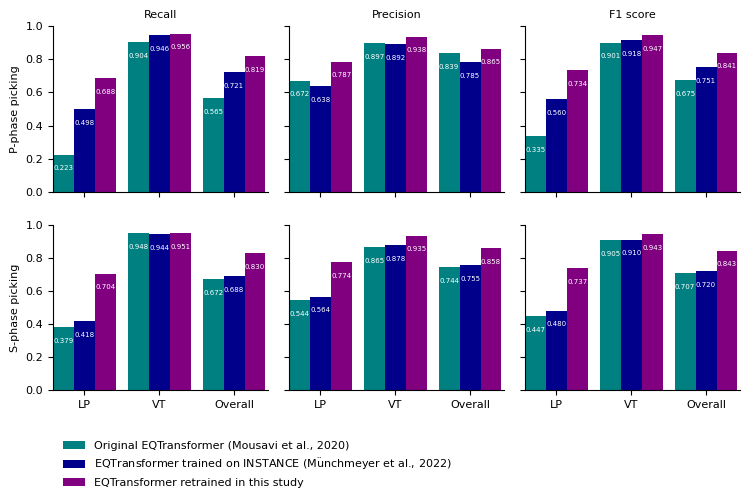

In [386]:
cm = 1/2.54
fig, axs = plt.subplots(2,3,figsize=(22.5*cm,12*cm),sharey="all",sharex="all") #,layout="constrained"
plt.subplots_adjust(hspace=0.2,wspace=0.1)

data_types=("LP","VT","Overall")
x = np.arange(len(data_types))
#x=np.array([0,1.5,3])
width = 0.28  # the width of the bars

metric_names=["Recall","Precision","F1 score"]
colors=["teal","darkblue","purple"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels={"vol_eqt":"EQTransformer retrained in this study",
        "org_eqt":"Original EQTransformer (Mousavi et al., 2020)",
        "int_eqt":r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)"}

fts=8
for i in range(3):
    p_metric_dict=p_metrics[metric_names[i]]
    s_metric_dict=s_metrics[metric_names[i]]
    ax=axs[0][i]

    # multiplier = 0
    fmt="{:.3f}"
    interval=width
    for k,(attribute, value) in enumerate(p_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(x + offset, value, width, label=labels[attribute],color=colors[k])
        ax.bar_label(rects, padding=-12,fmt=fmt,fontsize=fts-3,color="white")
        ax.spines[['right', 'top']].set_visible(False)
        # ax.set_yscale('log')
        # multiplier += 1
    ax.set_xticks(x + interval, data_types,fontsize=fts)
    ax.set_title(metric_names[i],fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0,1])
    
    
    # S
    ax=axs[1][i]

    # multiplier = 0
    for k,(attribute, value) in enumerate(s_metric_dict.items()):
        offset = interval* k
        rects = ax.bar(x + offset, value, width, label=labels[attribute],color=colors[k])
        ax.bar_label(rects, padding=-12,fmt=fmt,fontsize=fts-3,color="white")
        ax.spines[['right', 'top']].set_visible(False)
        # ax.set_yscale('log')
        # multiplier += 1
    ax.set_xticks(x + interval, data_types,fontsize=fts)
    ax.set_ylim([0,1])
    ax.set_xlim(x[0]-0.5*interval,x[-1]+2.6*interval)
    ax.tick_params(labelsize=fts)
    

# axs[0][0].set_title("P picking")
# axs[0][1].set_title("S picking")
axs[1][0].legend(loc='lower left',  bbox_to_anchor=(0.0, -0.65, 0.5, 0.1),frameon=False,fontsize=fts, ncols=1)
axs[0][0].set_ylabel("P-phase picking",fontsize=fts)
axs[1][0].set_ylabel("S-phase picking",fontsize=fts)
# plt.savefig("NCEDCperf_comp_eqt.pdf",bbox_inches="tight",pad_inches=0)

Plot PhaseNet

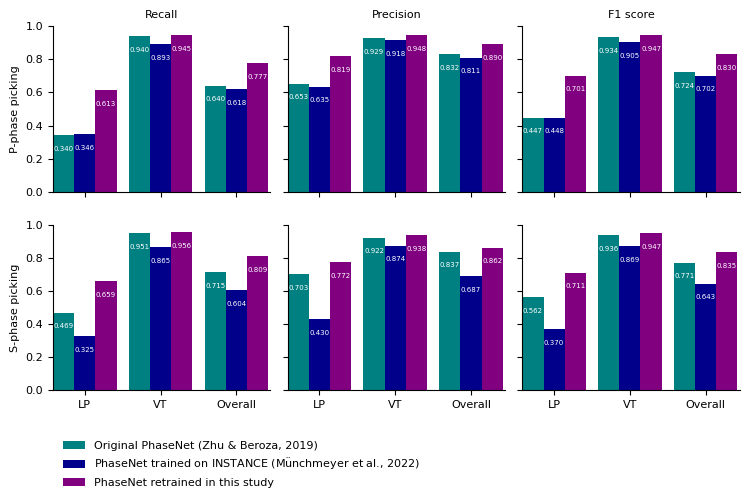

In [387]:
pred_dir_path=Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/")
data_type_dirs=("ncedc_lp_pred","ncedc_vt_pred","ncedc_pred")

p_metric_dict={}
s_metric_dict={}
p_precision_dict={x:[] for x in pn_pred_dirs}
s_precision_dict={x:[] for x in pn_pred_dirs}
p_recall_dict={x:[] for x in pn_pred_dirs}
s_recall_dict={x:[] for x in pn_pred_dirs}
p_f1score_dict={x:[] for x in pn_pred_dirs}
s_f1score_dict={x:[] for x in pn_pred_dirs}
for model_name in pn_pred_dirs:
    for data_type in data_type_dirs:
        pred_df=pd.read_csv(pred_dir_path/data_type/"task0"/model_name/"test_metrics.csv")
        p_row=pred_df[np.isclose(pred_df["prob_thre"],p_thre_dict[model_name])].iloc[0]
        s_row=pred_df[np.isclose(pred_df["prob_thre"],s_thre_dict[model_name])].iloc[0]
        assert np.abs(p_row["prob_thre"]-p_thre_dict[model_name])<1e-6, f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"]-s_thre_dict[model_name])<1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])

p_metrics={"Recall":p_recall_dict,"Precision":p_precision_dict,"F1 score":p_f1score_dict}
s_metrics={"Recall":s_recall_dict,"Precision":s_precision_dict,"F1 score":s_f1score_dict}

cm = 1/2.54
fig, axs = plt.subplots(2,3,figsize=(22.5*cm,12*cm),sharey="all",sharex="all") #,layout="constrained"
plt.subplots_adjust(hspace=0.2,wspace=0.08)

data_types=("LP","VT","Overall")
x = np.arange(len(data_types))
#x=np.array([0,1.5,3])
width = 0.28  # the width of the bars

metric_names=["Recall","Precision","F1 score"]
colors=["teal","darkblue","purple"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels={"org_eqt":"Original EQTransformer (Mousavi et al., 2020)",
        "int_eqt":r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)","vol_eqt":"EQTransformer retrained in this study",
        "org_pn":"Original PhaseNet (Zhu & Beroza, 2019)",
        "int_pn":r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
        "vol_pn":"PhaseNet retrained in this study",}

fts=8
for i in range(3):
    p_metric_dict=p_metrics[metric_names[i]]
    s_metric_dict=s_metrics[metric_names[i]]
    ax=axs[0][i]

    fmt="{:.3f}"
    interval=width
    for k,(attribute, value) in enumerate(p_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(x + offset, value, width, label=labels[attribute],color=colors[k])
        ax.bar_label(rects, padding=-12,fmt=fmt,fontsize=fts-3,color="white")
        ax.spines[['right', 'top']].set_visible(False)

    ax.set_xticks(x + interval, data_types,fontsize=fts)
    ax.set_title(metric_names[i],fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0,1])
    
    
    # S
    ax=axs[1][i]

    # multiplier = 0
    for k,(attribute, value) in enumerate(s_metric_dict.items()):
        offset = interval* k
        rects = ax.bar(x + offset, value, width, label=labels[attribute],color=colors[k])
        ax.bar_label(rects, padding=-12,fmt=fmt,fontsize=fts-3,color="white")
        ax.spines[['right', 'top']].set_visible(False)

    ax.set_xticks(x + interval, data_types,fontsize=fts)
    ax.set_ylim([0,1])
    ax.set_xlim(x[0]-0.5*interval,x[-1]+2.6*interval)
    ax.tick_params(labelsize=fts)

axs[1][0].legend(loc='lower left',  bbox_to_anchor=(0.0, -0.65, 0.5, 0.1),frameon=False,fontsize=fts, ncols=1)
axs[0][0].set_ylabel("P-phase picking",fontsize=fts)
axs[1][0].set_ylabel("S-phase picking",fontsize=fts)
# plt.savefig("NCEDCperf_comp_pn.pdf",bbox_inches="tight",pad_inches=0)

Plot EQTransformer and PhaseNet together

In [55]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = [
    "ncedc_vt_pred",
    "ncedc_lp_pred",
]  # ['rg_and_noise_pred','lp_and_noise_pred']
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/")

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

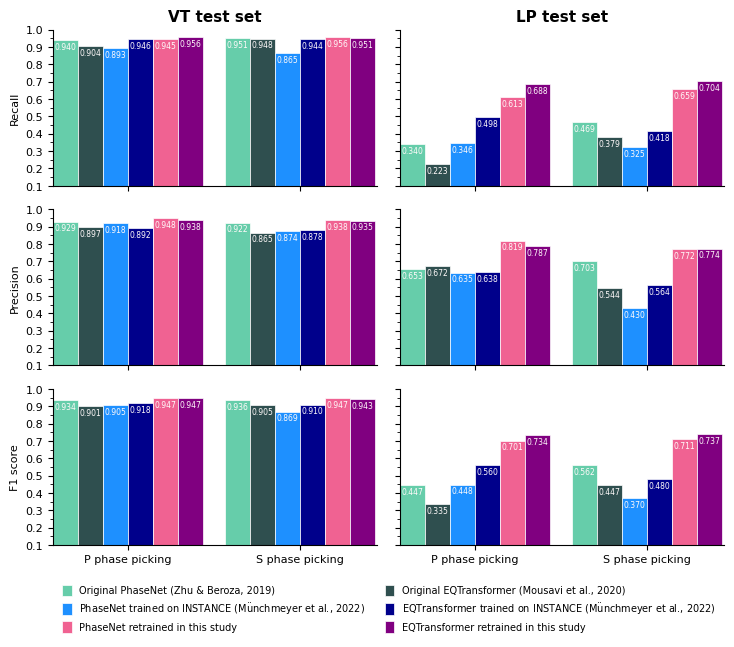

In [56]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 17 * cm), sharey="all", sharex="all"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.07)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.2
# x=np.array([0,1.5,3])
width = 0.32  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = [
    "mediumaquamarine",
    "darkslategrey",
    "dodgerblue",
    "darkblue",
    "#F06292",
    "purple",
]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}

fts = 8
for i in range(3):
    for j in range(2):
        metric_dict = metrics[metric_names[i]][j]

        ax = axs[i][j]

        fmt = "{:.3f}"
        interval = width
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                edgecolor="white",
                color=colors[k],
                linewidth=0.5,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=-8, fmt=fmt, fontsize=fts - 2.5, color="snow")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        # ax.set_title(metric_names[i],fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.1, 1])
        ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    axs[i][0].set_ylabel(metric_names[i], fontsize=fts)

handles, legend_labels = axs[-1][0].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]
#
leg = axs[-1][0].legend(
    [handles[idx] for idx in legend_label_order],
    [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.0,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.0, -0.62, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncols=2,
    # columnspacing=0.75,
)
# for t in leg.get_texts():
#     t.set_verticalalignment("center")
# leg._legend_box.set_height(leg.get_bbox_to_anchor().height*.5)

axs[0][0].set_title("VT test set", fontsize=fts + 3, weight="bold")
axs[0][1].set_title("LP test set", fontsize=fts + 3, weight="bold")
# plt.savefig("NCEDCperf_comp_pn_eqt.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

Stead

In [69]:
pred_dirs = [
    "org_pn",
    "org_eqt",
    "std_pn",
    "std_eqt",
    "int_pn",
    "int_eqt",
    "vol_pn",
    "vol_eqt",
]
data_types_plotted = [
    "ncedc_vt_pred",
    "ncedc_lp_pred",
]  # ['rg_and_noise_pred','lp_and_noise_pred']
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/")

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

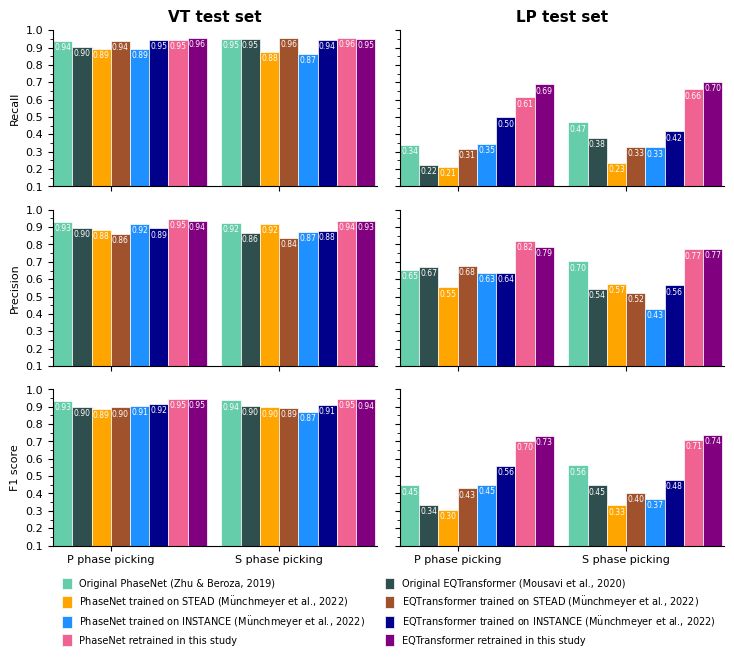

In [74]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 17 * cm), sharey="all", sharex="all"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.07)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.8
# x=np.array([0,1.5,3])
width = 0.32  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = [
    "mediumaquamarine",
    "darkslategrey",
    "orange",
    "sienna",
    "dodgerblue",
    "darkblue",
    "#F06292",
    "purple",
]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "std_eqt": r"EQTransformer trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "std_pn": r"PhaseNet trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}

fts = 8
for i in range(3):
    for j in range(2):
        metric_dict = metrics[metric_names[i]][j]

        ax = axs[i][j]

        fmt = "{:.2f}"
        interval = width
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                edgecolor="white",
                color=colors[k],
                linewidth=0.5,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=-8, fmt=fmt, fontsize=fts - 2.5, color="snow")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        # ax.set_title(metric_names[i],fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.1, 1])
        ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 7.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    axs[i][0].set_ylabel(metric_names[i], fontsize=fts)

handles, legend_labels = axs[-1][0].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 6, 1, 3, 5, 7]
#
leg = axs[-1][0].legend(
    [handles[idx] for idx in legend_label_order],
    [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.0,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.0, -0.7, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncols=2,
    # columnspacing=0.75,
)
# for t in leg.get_texts():
#     t.set_verticalalignment("center")
# leg._legend_box.set_height(leg.get_bbox_to_anchor().height*.5)

axs[0][0].set_title("VT test set", fontsize=fts + 3, weight="bold")
axs[0][1].set_title("LP test set", fontsize=fts + 3, weight="bold")
# plt.savefig(
#     "NCEDCperf_comp_pn_eqt_include_stead.pdf",
#     dpi=600,
#     bbox_inches="tight",
#     pad_inches=0,
# )
# plt.savefig(
#     "NCEDCperf_comp_pn_eqt_include_stead.jpg",
#     dpi=600,
#     bbox_inches="tight",
#     pad_inches=0,
# )

# Cross-domain test: Japan tectonic LFEs

In [76]:
data_path_jp_tec_lp = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp")

dataset_jp_tec_lp = sbd.WaveformDataset(
    data_path_jp_tec_lp,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_jp_tec_lp))
dataset_jp_tec_lp._metadata["split"] = "test"

6224


In [21]:
data_path_jp_tec_lp = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp")

dataset_jp_tec_lp_ENZ = sbd.WaveformDataset(
    data_path_jp_tec_lp,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_jp_tec_lp_ENZ))
dataset_jp_tec_lp_ENZ._metadata["split"] = "test"

6224


In [77]:
targets_path_jp_teclp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_jp_teclp/japan_tec_lp"
)
try:
    targets_path_jp_teclp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_jp_teclp} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_jp_teclp/japan_tec_lp exists


In [67]:
replace_if_exist = False
generate_task0(
    dataset=dataset_jp_tec_lp,
    output=targets_path_jp_teclp,
    sampling_rate=100,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)
generate_task1(
    dataset=dataset_jp_tec_lp,
    output=targets_path_jp_teclp,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)
generate_task23(
    dataset=dataset_jp_tec_lp,
    output=targets_path_jp_teclp,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)

100%|██████████| 6224/6224 [00:02<00:00, 2639.66it/s]


Test the retrained model

In [71]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [72]:
tp_thre = 0.5

model = vol_eqt
target_i=targets_path_jp_teclp
dataset_i=dataset_jp_tec_lp

eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"vol_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.22]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 152819.25it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.220


In [73]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [77]:
model = vol_pn
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"vol_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.39, 0.34]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 356723.03it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340


Test the original model

In [28]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [78]:
tp_thre = 0.5


model = org_eqt
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"org_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.001, 0.01]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 172080.82it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010


In [78]:
tp_thre = 0.5


model = org_eqt2
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"org_eqt_nonconservative",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.26, 0.15]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:08<00:00, 774.34it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [24]:
tp_thre = 0.5


model = org_pn
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp_ENZ
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"org_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.25, 0.19]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:04<00:00, 1452.60it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [80]:
tp_thre = 0.5


model = eqt_instance
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"int_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.04]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 249506.33it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.040


In [81]:
tp_thre = 0.5


model = pn_instance
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"int_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.13, 0.05]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 264077.16it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


Test the model trained on STEAD

In [67]:
tp_thre = 0.5


model = eqt_stead
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"std_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.02, 0.01]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/std_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:08<00:00, 773.20it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.020


Probability threshold: 0.010


In [68]:
tp_thre = 0.5


model = pn_stead
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"std_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp",
    prob_thres=np.array([0.01, 0.04]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/japan_tec_lp_pred/task0/std_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:01<00:00, 6192.86it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.010


Probability threshold: 0.040


Plot

In [84]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = ["japan_tec_lp_pred"]

In [85]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = ["japan_tec_lp_pred"]
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/")

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

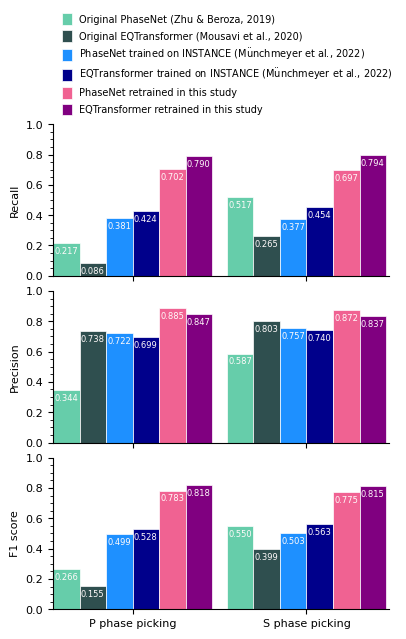

In [86]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 1, figsize=(11 * cm, 16 * cm), sharex="all", squeeze=False
)  # ,layout="constrained"
# fig.delaxes(axs[1][0])
plt.subplots_adjust(hspace=0.1, wspace=0.25)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.1
# x=np.array([0,1.5,3])
width = 0.32  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = [
    "mediumaquamarine",
    "darkslategrey",
    "dodgerblue",
    "darkblue",
    "#F06292",
    "purple",
]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}

fts = 8
subplot_ids = [0, 1, 3]
for i in range(3):
    for j in range(1):
        metric_dict = metrics[metric_names[i]][j]

        ax = axs[i][j]
        ax.set_ylabel(metric_names[i], fontsize=fts)

        fmt = "{:.3f}"
        interval = width
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                edgecolor="white",
                color=colors[k],
                linewidth=0.5,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=-9, fmt=fmt, fontsize=fts - 2, color="snow")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        # ax.set_title(metric_names[i],fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))

handles, legend_labels = axs[0][0].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]
#
leg = axs[0][0].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.0,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(0.0, 1.0, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.75,
)
# for t in leg.get_texts():
#     t.set_verticalalignment("center")
# leg._legend_box.set_height(leg.get_bbox_to_anchor().height*.5)

# axs[0][0].set_title("VT test set", fontsize=fts + 3, weight="bold")
# axs[0][0].set_title("LP test set", fontsize=fts + 3, weight="bold")
# plt.savefig(
#     "Jp_tec_lp_perf_comp_pn_eqt.pdf", dpi=600, bbox_inches="tight", pad_inches=0
# )

Include Stead

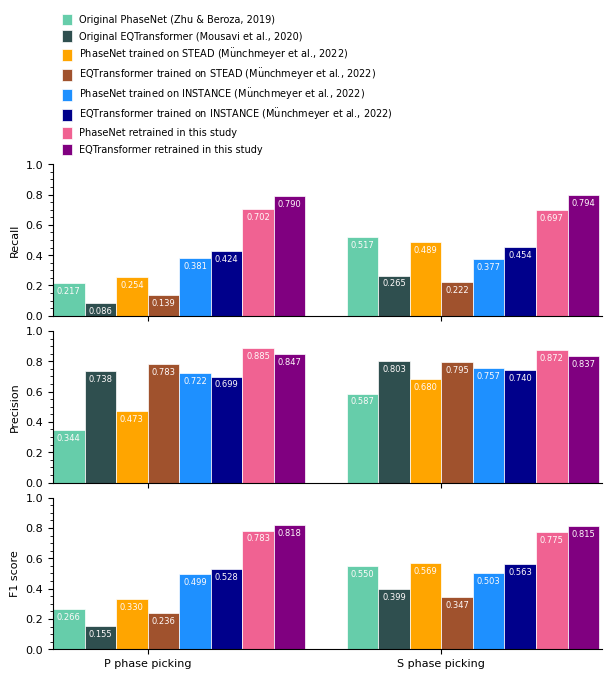

In [87]:
pred_dirs = [
    "org_pn",
    "org_eqt",
    "std_pn",
    "std_eqt",
    "int_pn",
    "int_eqt",
    "vol_pn",
    "vol_eqt",
]
data_types_plotted = ["japan_tec_lp_pred"]

# pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = ["japan_tec_lp_pred"]
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/")

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 1, figsize=(18 * cm, 16 * cm), sharex="all", squeeze=False
)  # ,layout="constrained"
# fig.delaxes(axs[1][0])
plt.subplots_adjust(hspace=0.1, wspace=0.25)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.7
# x=np.array([0,1.5,3])
width = 0.29  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = [
    "mediumaquamarine",
    "darkslategrey",
    "orange",
    "sienna",
    "dodgerblue",
    "darkblue",
    "#F06292",
    "purple",
]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "std_eqt": r"EQTransformer trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "std_pn": r"PhaseNet trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}

fts = 8
# subplot_ids = [0, 1, 3]
for i in range(3):
    for j in range(1):
        metric_dict = metrics[metric_names[i]][j]

        ax = axs[i][j]
        ax.set_ylabel(metric_names[i], fontsize=fts)

        fmt = "{:.3f}"
        interval = width
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                edgecolor="white",
                color=colors[k],
                linewidth=0.5,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=-9, fmt=fmt, fontsize=fts - 2, color="snow")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        # ax.set_title(metric_names[i],fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 7.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))

handles, legend_labels = axs[0][0].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]
#
leg = axs[0][0].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.0,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(0.0, 1.0, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.75,
)
# for t in leg.get_texts():
#     t.set_verticalalignment("center")
# leg._legend_box.set_height(leg.get_bbox_to_anchor().height*.5)

# axs[0][0].set_title("VT test set", fontsize=fts + 3, weight="bold")
# axs[0][0].set_title("LP test set", fontsize=fts + 3, weight="bold")
# plt.savefig(
#     "Jp_tec_lp_perf_comp_pn_eqt_include_stead.pdf",
#     dpi=600,
#     bbox_inches="tight",
#     pad_inches=0,
# )

In [76]:
metric_dict

{'org_pn': [0.2660224807730231, 0.5497106331519391],
 'org_eqt': [0.1547533438803394, 0.3986321446018564],
 'int_pn': [0.4985799936888608, 0.5029836172290333],
 'int_eqt': [0.528135932033983, 0.5626572722697535],
 'vol_pn': [0.7831541218637993, 0.7748691099476439],
 'vol_eqt': [0.8176152887411715, 0.8148333333333334]}

In [119]:
legend_labels

['Original PhaseNet (Zhu & Beroza, 2019)',
 'Original EQTransformer (Mousavi et al., 2020)',
 'PhaseNet trained on INSTANCE (M$\\rm{\\"u}$nchmeyer et al., 2022)',
 'EQTransformer trained on INSTANCE (M$\\rm{\\"u}$nchmeyer et al., 2022)',
 'PhaseNet retrained in this study',
 'EQTransformer retrained in this study']

# Cross-domain test: Cascade lp

In [62]:
data_path_cascade = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade")

dataset_cascade = sbd.WaveformDataset(
    data_path_cascade,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_cascade))
dataset_cascade._metadata["split"] = "test"

1620


In [63]:
dataset_cascade_lp = dataset_cascade.filter(
    (dataset_cascade.metadata["source_type"] == "lp")
    | (dataset_cascade.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_cascade_vt = dataset_cascade.filter(
    (dataset_cascade.metadata["source_type"] != "lp")
    | (dataset_cascade.metadata["source_type"] == "noise"),
    inplace=False,
)

In [64]:
data_path_cacade = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade")

dataset_cascade_ENZ = sbd.WaveformDataset(
    data_path_cacade,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_cascade_ENZ))
dataset_cascade_ENZ._metadata["split"] = "test"
dataset_cascade_ENZ_lp = dataset_cascade_ENZ.filter(
    (dataset_cascade_ENZ.metadata["source_type"] == "lp")
    | (dataset_cascade_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_cascade_ENZ_vt = dataset_cascade_ENZ.filter(
    (dataset_cascade_ENZ.metadata["source_type"] != "lp")
    | (dataset_cascade_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

1620


In [65]:
targets_path_lp_and_rg_cascade = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade"
)
try:
    targets_path_lp_and_rg_cascade.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_cascade} exists")

targets_path_lp_cascade = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_lp"
)
try:
    targets_path_lp_cascade.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_cascade} exists")

targets_path_rg_cascade = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_vt"
)
try:
    targets_path_rg_cascade.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_cascade} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_vt exists


In [66]:
replace_if_exist = False
generate_task0(
    dataset=dataset_cascade,
    output=targets_path_lp_and_rg_cascade,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

The existing file will be replaced.


100%|██████████| 1620/1620 [00:01<00:00, 1088.43it/s]


In [67]:
replace_if_exist = False
generate_task0(
    dataset=dataset_cascade_lp,
    output=targets_path_lp_cascade,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

The existing file will be replaced.


100%|██████████| 810/810 [00:00<00:00, 1299.62it/s]


In [68]:
replace_if_exist = False
generate_task0(
    dataset=dataset_cascade_vt,
    output=targets_path_rg_cascade,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

The existing file will be replaced.


100%|██████████| 810/810 [00:00<00:00, 1824.07it/s]


Test the retrained model

In [69]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [70]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.22]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 145776.16it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 124178.01it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 329523.40it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.2200


In [71]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 325778.99it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 327680.00it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 324611.72it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


Test the original model

In [72]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [73]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 150840.75it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 255078.18it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 327458.91it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100


In [74]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 212131.14it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 314485.44it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 327017.64it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [75]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]
dataset_list = [dataset_cascade_ENZ, dataset_cascade_ENZ_lp, dataset_cascade_ENZ_vt]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/org_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/1620 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 4920.89it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 3598.46it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5410.62it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [76]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 135681.07it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 330099.71it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 315244.15it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.0400


In [77]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 319378.26it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 328186.46it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_cascade/cascade_vt_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 313788.33it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


# Cross-domain test: Cascade + northern california

In [15]:
data_path_westernus = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus")

dataset_westernus = sbd.WaveformDataset(
    data_path_westernus,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_westernus))
# dataset_westernus._metadata["split"] = "test"

11302


In [16]:
np.all(dataset_westernus._metadata["split"].values == "test")

True

In [17]:
dataset_westernus_lp = dataset_westernus.filter(
    (dataset_westernus.metadata["source_type"] == "lp")
    | (dataset_westernus.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_westernus_vt = dataset_westernus.filter(
    (dataset_westernus.metadata["source_type"] != "lp")
    | (dataset_westernus.metadata["source_type"] == "noise"),
    inplace=False,
)

In [18]:
data_path_westernus = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus")

dataset_westernus_ENZ = sbd.WaveformDataset(
    data_path_westernus,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_westernus_ENZ))
dataset_westernus_ENZ._metadata["split"] = "test"
dataset_westernus_ENZ_lp = dataset_westernus_ENZ.filter(
    (dataset_westernus_ENZ.metadata["source_type"] == "lp")
    | (dataset_westernus_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_westernus_ENZ_vt = dataset_westernus_ENZ.filter(
    (dataset_westernus_ENZ.metadata["source_type"] != "lp")
    | (dataset_westernus_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

11302


In [20]:
targets_path_lp_and_rg_westernus = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus"
)
try:
    targets_path_lp_and_rg_westernus.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_westernus} exists")

targets_path_lp_westernus = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_lp"
)
try:
    targets_path_lp_westernus.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_westernus} exists")

targets_path_rg_westernus = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_vt"
)
try:
    targets_path_rg_westernus.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_westernus} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_vt exists


In [21]:
replace_if_exist = False
generate_task0(
    dataset=dataset_westernus,
    output=targets_path_lp_and_rg_westernus,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)
generate_task1(
    dataset=dataset_westernus,
    output=targets_path_lp_and_rg_westernus,
    sampling_rate=100,
    noise_before_events=False,
    replace_if_exist=replace_if_exist,
)
generate_task23(
    dataset=dataset_westernus,
    output=targets_path_lp_and_rg_westernus,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)

100%|██████████| 11302/11302 [00:03<00:00, 2873.58it/s]


In [22]:
replace_if_exist = False
generate_task0(
    dataset=dataset_westernus_lp,
    output=targets_path_lp_westernus,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)
generate_task1(
    dataset=dataset_westernus_lp,
    output=targets_path_lp_westernus,
    sampling_rate=100,
    noise_before_events=False,
    replace_if_exist=replace_if_exist,
)
generate_task23(
    dataset=dataset_westernus_lp,
    output=targets_path_lp_westernus,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)

100%|██████████| 5651/5651 [00:01<00:00, 2843.91it/s]


In [23]:
replace_if_exist = False
generate_task0(
    dataset=dataset_westernus_vt,
    output=targets_path_rg_westernus,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)
generate_task1(
    dataset=dataset_westernus_vt,
    output=targets_path_rg_westernus,
    sampling_rate=100,
    noise_before_events=False,
    replace_if_exist=replace_if_exist,
)
generate_task23(
    dataset=dataset_westernus_vt,
    output=targets_path_rg_westernus,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)

100%|██████████| 5651/5651 [00:01<00:00, 2983.41it/s]


In [24]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


Test the retrained model

In [25]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.22]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:00<00:00, 338684.84it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 290775.85it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 350253.61it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.2200


In [26]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [27]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:00<00:00, 361391.04it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 353576.67it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 336944.33it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


Test the original model

In [28]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [29]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:00<00:00, 363837.50it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 362393.92it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 326285.23it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100


In [30]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:00<00:00, 371182.00it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 334519.04it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 363723.04it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [31]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
# dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]
dataset_list = [
    dataset_westernus_ENZ,
    dataset_westernus_ENZ_lp,
    dataset_westernus_ENZ_vt,
]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 6172.22it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5922.42it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 6405.55it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [37]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:00<00:00, 353832.67it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 339366.17it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 373265.91it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.0400


In [38]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:00<00:00, 359710.01it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 362316.36it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_westernus/westernus_vt_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 358231.24it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


# Task 123 (Munchyemer et al., 2022)

Retrained model

In [125]:
vol_eqt_lightning_model = models.EQTransformerLit()
vol_eqt_lightning_model.model = vol_eqt

In [126]:
vol_pn_lightning_model = models.PhaseNetLit()
vol_pn_lightning_model.model = vol_pn

Original model

In [165]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [166]:
org_eqt_lightning_model = models.EQTransformerLit()
org_eqt_lightning_model.model = org_eqt

In [167]:
org_eqt_nonconservative_lightning_model = models.EQTransformerLit()
org_eqt_nonconservative_lightning_model.model = org_eqt2

In [168]:
org_pn_lightning_model = models.PhaseNetLit()
org_pn_lightning_model.model = org_pn

Models trained on INSTANCE dataset

In [169]:
int_eqt_lightning_model = models.EQTransformerLit()
int_eqt_lightning_model.model = eqt_instance

In [170]:
int_pn_lightning_model = models.PhaseNetLit()
int_pn_lightning_model.model = pn_instance

In [171]:
lightning_models_dict = {
    "vol_eqt": vol_eqt_lightning_model,
    "vol_pn": vol_pn_lightning_model,
    "org_eqt": org_eqt_lightning_model,
    "org_pn": org_pn_lightning_model,
    "int_eqt": int_eqt_lightning_model,
    "int_pn": int_pn_lightning_model,
    "org_eqt_nonconservative": org_eqt_nonconservative_lightning_model,
}

In [172]:
for exp_name, lightning_model in lightning_models_dict.items():
    if exp_name != "org_pn":
        print(exp_name)

vol_eqt
vol_pn
org_eqt
int_eqt
int_pn
org_eqt_nonconservative


In [44]:
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

for exp_name, lightning_model in lightning_models_dict.items():
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        if exp_name != "org_pn":
            eval_tasks123(
                model=lightning_model,
                dataset=dataset_i,
                targets=target_i,
                exp_name=exp_name,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
                sets=["dev","test"],
                batchsize=1024,
                num_workers=32,
            )

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 351476.44it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 343106.74it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 253536.49it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 351371.54it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 346713.44it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 252004.77it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 342696.45it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 361108.14it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 257412.25it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 363553.70it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 265257.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 301169.90it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 348869.96it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 364569.54it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 213154.57it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 341128.75it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 356286.02it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 361810.12it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 303730.66it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 338027.55it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 348064.30it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 359019.92it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 361929.33it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 363609.88it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 352926.51it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 367225.23it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 352217.94it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 359653.64it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 363866.89it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 362610.77it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 341268.02it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 355920.14it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 340090.53it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 368346.89it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 345093.03it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 355758.77it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [173]:
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

# for exp_name, lightning_model in lightning_models_dict.items():
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_tasks123(
        model=org_eqt_nonconservative_lightning_model,
        dataset=dataset_i,
        targets=target_i,
        exp_name="org_eqt_nonconservative",
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        sets=["dev", "test"],
        batchsize=1024,
        num_workers=32,
    )

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 334180.78it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 367538.60it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 357325.44it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 366305.75it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 346975.13it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 335615.32it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [47]:
targets_path_lp_and_rg

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets/all')

In [16]:
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset_ENZ, dataset_ENZ_lp_and_noise, dataset_ENZ_rg_and_noise]
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_tasks123(
        model=org_pn_lightning_model,
        dataset=dataset_i,
        targets=target_i,
        exp_name="org_pn",
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test",
        sets=["dev", "test"],
        batchsize=1024,
        num_workers=32,
    )

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 292631.23it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 361358.84it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10105/10105 [00:00<00:00, 370083.49it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 356873.10it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 10193/10193 [00:00<00:00, 353140.00it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 276559.65it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [16]:
pred_dirs

NameError: name 'pred_dirs' is not defined

In [174]:
root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Test")

pred_dirs = [root_save_dir / f"{x.name}_pred" for x in target_path_list]
for pred_dir in pred_dirs:
    # collect_task0_results_dev(pred_dir/"task0")
    collect_task123_results(pred_dir / "task123", parse_filename=False)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.43it/s]


# Plot Task123

Plot task1

In [3]:
# eqt_pred_dirs = ("org_eqt", "int_eqt", "vol_eqt")
eqt_pred_dirs = ("org_eqt_nonconservative", "int_eqt", "vol_eqt")
pn_pred_dirs = ("org_pn", "int_pn", "vol_pn")
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test/")
data_type_dirs = ("lp_and_noise_pred", "rg_and_noise_pred", "all_pred")

In [4]:
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]

/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/org_eqt_nonconservative/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/int_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/vol_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/org_eqt_nonconservative/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/int_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/vol_eqt/test_task1.csv


Text(0.5, 0, 'False positive rate')

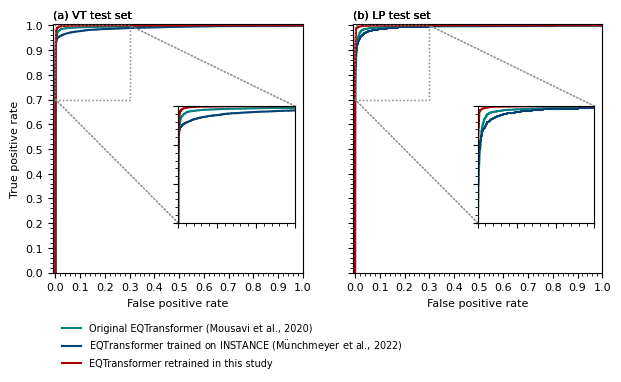

In [5]:
labels = {
    # "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
colors = {
    "org_pn": "#96DEAE",
    # "org_eqt": "#008080",
    "org_eqt_nonconservative": "#008080",
    "int_pn": "#0074B7",
    "int_eqt": "#024376",
    "vol_pn": "#D0565C",
    "vol_eqt": "#AE0000",
}
cm = 1 / 2.54
fig, axs = plt.subplots(
    1, 2, figsize=(18 * cm, 16 * cm), sharey="all", sharex="all", squeeze=False
)
plt.subplots_adjust(hspace=0.1, wspace=0.2)

text_labels = ["(a) VT test set", "(b) LP test set"]
for j, data_type in enumerate(data_types_plotted):
    ax = axs[0][j]
    axins = None
    for i, model_name in enumerate(eqt_pred_dirs):
        print(pred_dir_path / data_type / "task123" / model_name / "test_task1.csv")
        task1_pred = pd.read_csv(
            pred_dir_path / data_type / "task123" / model_name / "test_task1.csv"
        )
        task1_pred["trace_type_bin"] = task1_pred["trace_type"] == "earthquake"
        fpr, tpr, _ = roc_curve(
            task1_pred["trace_type_bin"], task1_pred["score_detection"]
        )
        auc = roc_auc_score(task1_pred["trace_type_bin"], task1_pred["score_detection"])

        ax.plot(
            fpr,  # false positive rate
            tpr,  # true positive rate
            label=f"{labels[model_name]}",  # (auc {auc:.5f})
            color=colors[model_name],
        )
        ax.set_aspect("equal")
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.02))
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.02))
        ax.set_xlim([-0.01, 1.0])
        ax.set_ylim([-0.0, 1.005])
        ax.tick_params(labelsize=fts)

        x1, x2, y1, y2 = 0.0, 0.3, 0.7, 1
        if axins is None:
            axins = ax.inset_axes(
                [0.5, 0.2, 0.47, 0.47],
                xlim=(x1, x2),
                ylim=(y1, y2),
                xticklabels=[],
                yticklabels=[],
            )
        axins.plot(
            fpr,
            tpr,
            # label=f"{labels[model_name]} (auc {auc:.5f})",
            color=colors[model_name],
        )
        axins.yaxis.set_major_locator(MultipleLocator(0.1))
        axins.yaxis.set_minor_locator(MultipleLocator(0.02))
        axins.xaxis.set_major_locator(MultipleLocator(0.1))
        axins.xaxis.set_minor_locator(MultipleLocator(0.02))
        axins.set_aspect("equal")
        rect, lines = ax.indicate_inset_zoom(
            axins, edgecolor="gray", linestyle="dotted", lw=1
        )
        for lin in lines:
            lin.set_linewidth(1)
            lin.set_linestyle("dotted")
            lin.set_color("gray")

        ax.text(
            0.0,
            1.02,
            text_labels[j],
            verticalalignment="bottom",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            color="black",
        )

axs[0][0].legend(
    # markerfirst=False,
    loc="lower left",
    bbox_to_anchor=(0.0, -0.42, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncol=1,
)
axs[0][0].set_ylabel("True positive rate", fontsize=fts)
# axs[1][0].set_ylabel("True positive rate", fontsize=fts)
axs[0][1].set_xlabel("False positive rate", fontsize=fts)
axs[0][0].set_xlabel("False positive rate", fontsize=fts)
# plt.savefig("task1_ROC_eqt.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/org_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/int_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/vol_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/org_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/int_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/vol_pn/test_task1.csv


Text(0.5, 0, 'False positive rate')

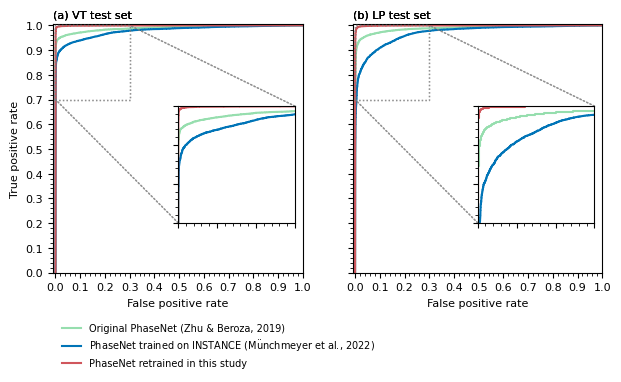

In [6]:
labels = {
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
colors = {
    "org_pn": "#96DEAE",
    "org_eqt_nonconservative": "#008080",
    "int_pn": "#0074B7",
    "int_eqt": "#024376",
    "vol_pn": "#D0565C",
    "vol_eqt": "#AE0000",
}
cm = 1 / 2.54
fig, axs = plt.subplots(
    1, 2, figsize=(18 * cm, 16 * cm), sharey="all", sharex="all", squeeze=False
)
plt.subplots_adjust(hspace=0.1, wspace=0.2)

text_labels = ["(a) VT test set", "(b) LP test set"]
for j, data_type in enumerate(data_types_plotted):
    ax = axs[0][j]
    axins = None
    for i, model_name in enumerate(pn_pred_dirs):
        print(pred_dir_path / data_type / "task123" / model_name / "test_task1.csv")
        task1_pred = pd.read_csv(
            pred_dir_path / data_type / "task123" / model_name / "test_task1.csv"
        )
        task1_pred["trace_type_bin"] = task1_pred["trace_type"] == "earthquake"
        fpr, tpr, _ = roc_curve(
            task1_pred["trace_type_bin"], task1_pred["score_detection"]
        )
        auc = roc_auc_score(task1_pred["trace_type_bin"], task1_pred["score_detection"])

        ax.plot(
            fpr,  # false positive rate
            tpr,  # true positive rate
            label=f"{labels[model_name]}",  # (auc {auc:.5f})
            color=colors[model_name],
        )
        ax.set_aspect("equal")
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.02))
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.02))
        ax.set_xlim([-0.01, 1.0])
        ax.set_ylim([-0.0, 1.005])
        ax.tick_params(labelsize=fts)

        x1, x2, y1, y2 = 0.0, 0.3, 0.7, 1
        if axins is None:
            axins = ax.inset_axes(
                [0.5, 0.2, 0.47, 0.47],
                xlim=(x1, x2),
                ylim=(y1, y2),
                xticklabels=[],
                yticklabels=[],
            )
        axins.plot(
            fpr,
            tpr,
            # label=f"{labels[model_name]} (auc {auc:.5f})",
            color=colors[model_name],
        )
        axins.yaxis.set_major_locator(MultipleLocator(0.1))
        axins.yaxis.set_minor_locator(MultipleLocator(0.02))
        axins.xaxis.set_major_locator(MultipleLocator(0.1))
        axins.xaxis.set_minor_locator(MultipleLocator(0.02))
        axins.set_aspect("equal")
        rect, lines = ax.indicate_inset_zoom(
            axins, edgecolor="gray", linestyle="dotted", lw=1
        )
        for lin in lines:
            lin.set_linewidth(1)
            lin.set_linestyle("dotted")
            lin.set_color("gray")

        ax.text(
            0.0,
            1.02,
            text_labels[j],
            verticalalignment="bottom",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            color="black",
        )

axs[0][0].legend(
    # markerfirst=False,
    loc="lower left",
    bbox_to_anchor=(0.0, -0.42, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncol=1,
)
axs[0][0].set_ylabel("True positive rate", fontsize=fts)
# axs[1][0].set_ylabel("True positive rate", fontsize=fts)
axs[0][1].set_xlabel("False positive rate", fontsize=fts)
axs[0][0].set_xlabel("False positive rate", fontsize=fts)
# plt.savefig("task1_ROC_pn.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/org_eqt_nonconservative/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/int_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/vol_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/org_eqt_nonconservative/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/int_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/vol_eqt/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/org_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/int_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/vol_pn/test_task1.csv
/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/org_pn/test_task1.csv
/home/zhongyiyuan/volp

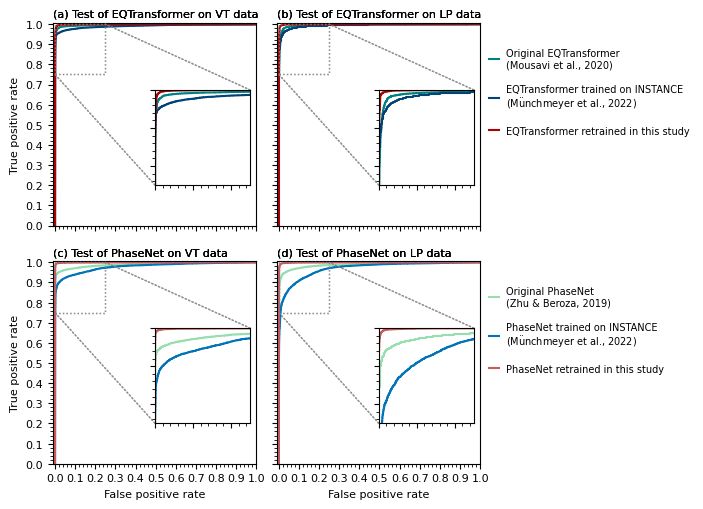

In [7]:
labels = {
    "org_eqt_nonconservative": "Original EQTransformer\n(Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained on INSTANCE\n"
    r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
colors = {
    "org_pn": "#96DEAE",
    "org_eqt_nonconservative": "#008080",
    "int_pn": "#0074B7",
    "int_eqt": "#024376",
    "vol_pn": "#D0565C",
    "vol_eqt": "#AE0000",
}
cm = 1 / 2.54
fig, axs = plt.subplots(
    2, 2, figsize=(14 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

text_labels = [
    ["(a) Test of EQTransformer on VT data", "(b) Test of EQTransformer on LP data"],
    ["(c) Test of PhaseNet on VT data", "(d) Test of PhaseNet on LP data"],
]
ls = ["-", "--"]
for k, m_pred_dirs in enumerate([eqt_pred_dirs, pn_pred_dirs]):
    for j, data_type in enumerate(data_types_plotted):
        ax = axs[k][j]
        axins = None
        for i, model_name in enumerate(m_pred_dirs):
            print(pred_dir_path / data_type / "task123" / model_name / "test_task1.csv")
            task1_pred = pd.read_csv(
                pred_dir_path / data_type / "task123" / model_name / "test_task1.csv"
            )
            task1_pred["trace_type_bin"] = task1_pred["trace_type"] == "earthquake"
            fpr, tpr, _ = roc_curve(
                task1_pred["trace_type_bin"], task1_pred["score_detection"]
            )
            auc = roc_auc_score(
                task1_pred["trace_type_bin"], task1_pred["score_detection"]
            )

            ax.plot(
                fpr,  # false positive rate
                tpr,  # true positive rate
                label=f"{labels[model_name]}",  # (auc {auc:.5f})
                color=colors[model_name],
                # ls=ls[k],
            )
            ax.set_aspect("equal")
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(MultipleLocator(0.02))
            ax.xaxis.set_major_locator(MultipleLocator(0.1))
            ax.xaxis.set_minor_locator(MultipleLocator(0.02))
            ax.set_xlim([-0.01, 1.0])
            ax.set_ylim([-0.0, 1.005])
            ax.tick_params(labelsize=fts)

            x1, x2, y1, y2 = 0.0, 0.25, 0.75, 1
            if axins is None:
                axins = ax.inset_axes(
                    [0.5, 0.2, 0.47, 0.47],
                    xlim=(x1, x2),
                    ylim=(y1, y2),
                    xticklabels=[],
                    yticklabels=[],
                )
            axins.plot(
                fpr,
                tpr,
                # label=f"{labels[model_name]} (auc {auc:.5f})",
                color=colors[model_name],
                # ls=ls[k],
            )
            axins.yaxis.set_major_locator(MultipleLocator(0.1))
            axins.yaxis.set_minor_locator(MultipleLocator(0.02))
            axins.xaxis.set_major_locator(MultipleLocator(0.1))
            axins.xaxis.set_minor_locator(MultipleLocator(0.02))
            axins.set_aspect("equal")
            rect, lines = ax.indicate_inset_zoom(
                axins, edgecolor="gray", linestyle="dotted", lw=1
            )
            for lin in lines:
                lin.set_linewidth(1)
                lin.set_linestyle("dotted")
                lin.set_color("gray")

            ax.text(
                0.0,
                1.02,
                text_labels[k][j],
                verticalalignment="bottom",
                horizontalalignment="left",
                transform=ax.transAxes,
                fontsize=fts,
                # weight="bold",
                color="black",
            )


axs[0][1].legend(
    # markerfirst=False,
    handlelength=1.0,
    handleheight=1,
    loc="lower left",
    bbox_to_anchor=(1.0, 0.4, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncol=1,
    labelspacing=1.5,
)
axs[1][1].legend(
    # markerfirst=False,
    handlelength=1.0,
    handleheight=1,
    loc="lower left",
    bbox_to_anchor=(1.0, 0.4, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    ncol=1,
    labelspacing=1.5,
)
axs[0][0].set_ylabel("True positive rate", fontsize=fts)
axs[1][0].set_ylabel("True positive rate", fontsize=fts)
axs[1][0].set_xlabel("False positive rate", fontsize=fts)
axs[1][1].set_xlabel("False positive rate", fontsize=fts)
plt.savefig("task1_ROC.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

AUC of task 1

In [8]:
lp_phase_auc = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/task123_metrics.csv"
)
lp_phase_auc = lp_phase_auc[["experiment", "test_det_auc"]].copy()
lp_phase_auc.rename(
    columns={"experiment": "Model", "test_det_auc": "LP"}, inplace=True
)  # (columns={"experiment": "Model", "test_det_auc": "LP"}, inplace=True)

rg_phase_auc = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/task123_metrics.csv"
)
rg_phase_auc = rg_phase_auc[["experiment", "test_det_auc"]].copy()
rg_phase_auc.rename(columns={"experiment": "Model", "test_det_auc": "VT"}, inplace=True)

merged_phase_auc = pd.merge(lp_phase_auc, rg_phase_auc, on="Model", how="outer")
model_names_dict = {
    "org_eqt_nonconservative": r"Original EQTransformer \cite {mousavi2020earthquake}",
    # "org_eqt": r"Original EQTransformer \cite {mousavi2020earthquake}",
    "int_eqt": r"EQTransformer trained on INSTANCE \cite{munchmeyer2022picker}",
    "vol_eqt": r"EQTransformer retrained in this study",
    "org_pn": r"Original PhaseNet \cite{zhu2019phasenet}",
    "int_pn": r"PhaseNet trained on INSTANCE \cite{munchmeyer2022picker}",
    "vol_pn": r"PhaseNet retrained in this study",
}
merged_phase_auc.replace(
    model_names_dict,
    inplace=True,
)

In [9]:
merged_phase_auc

,Model,LP,VT
0,EQTransformer trained on INSTANCE \cite{munchm...,0.993354,0.990668
1,PhaseNet trained on INSTANCE \cite{munchmeyer2...,0.969465,0.978444
2,org_eqt,0.977625,0.983925
3,Original EQTransformer \cite {mousavi2020earth...,0.993866,0.994810
4,Original PhaseNet \cite{zhu2019phasenet},0.988487,0.989414
5,org_pn_incorrect_component,0.993190,0.993691
6,EQTransformer retrained in this study,0.999328,0.999400
7,PhaseNet retrained in this study,0.999198,0.999397


In [10]:
print(
    merged_phase_auc.style.format({"LP": "{:.4f}", "VT": "{:.4f}"})
    .hide(axis="index")
    .to_latex()
)

\begin{tabular}{lrr}
Model & LP & VT \\
EQTransformer trained on INSTANCE \cite{munchmeyer2022picker} & 0.9934 & 0.9907 \\
PhaseNet trained on INSTANCE \cite{munchmeyer2022picker} & 0.9695 & 0.9784 \\
org_eqt & 0.9776 & 0.9839 \\
Original EQTransformer \cite {mousavi2020earthquake} & 0.9939 & 0.9948 \\
Original PhaseNet \cite{zhu2019phasenet} & 0.9885 & 0.9894 \\
org_pn_incorrect_component & 0.9932 & 0.9937 \\
EQTransformer retrained in this study & 0.9993 & 0.9994 \\
PhaseNet retrained in this study & 0.9992 & 0.9994 \\
\end{tabular}



Matthews Correlation Coefficient for task 2

In [11]:
lp_phase_mcc = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Test/lp_and_noise_pred/task123/task123_metrics.csv"
)
lp_phase_mcc = lp_phase_mcc[["experiment", "test_phase_mcc"]].copy()
lp_phase_mcc.rename(
    columns={"experiment": "Model", "test_phase_mcc": "LP"}, inplace=True
)  # (columns={"experiment": "Model", "test_phase_mcc": "LP"}, inplace=True)

rg_phase_mcc = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Test/rg_and_noise_pred/task123/task123_metrics.csv"
)
rg_phase_mcc = rg_phase_mcc[["experiment", "test_phase_mcc"]].copy()
rg_phase_mcc.rename(
    columns={"experiment": "Model", "test_phase_mcc": "VT"}, inplace=True
)
# rg_phase_mcc = rg_phase_mcc.iloc[1:].copy()

In [12]:
lp_phase_mcc

,Model,LP
0,int_eqt,0.771690
1,int_pn,0.832974
2,org_eqt,0.789882
3,org_eqt_nonconservative,0.792598
4,org_pn,0.883942
5,org_pn_incorrect_component,0.733293
6,vol_eqt,0.962108
7,vol_pn,0.956960


In [13]:
rg_phase_mcc

,Model,VT
0,int_eqt,0.942206
1,int_pn,0.946266
2,org_eqt,0.908579
3,org_eqt_nonconservative,0.957352
4,org_pn,0.967951
5,org_pn_incorrect_component,0.935423
6,vol_eqt,0.978736
7,vol_pn,0.976445


In [14]:
merged_phase_mcc = pd.merge(lp_phase_mcc, rg_phase_mcc, on="Model", how="outer")
merged_phase_mcc.replace(
    {
        # "org_eqt": r"Original EQTransformer \cite {mousavi2020earthquake}",
        "org_eqt_nonconservative": r"Original EQTransformer \cite {mousavi2020earthquake}",
        "int_eqt": r"EQTransformer trained on INSTANCE \cite{munchmeyer2022picker}",
        "vol_eqt": r"EQTransformer retrained in this study",
        "org_pn": r"Original PhaseNet \cite{zhu2019phasenet}",
        "int_pn": r"PhaseNet trained on INSTANCE \cite{munchmeyer2022picker}",
        "vol_pn": r"PhaseNet retrained in this study",
    },
    inplace=True,
)

In [15]:
print(
    merged_phase_mcc.style.format({"LP": "{:.4f}", "VT": "{:.4f}"})
    .hide(axis="index")
    .to_latex()
)

\begin{tabular}{lrr}
Model & LP & VT \\
EQTransformer trained on INSTANCE \cite{munchmeyer2022picker} & 0.7717 & 0.9422 \\
PhaseNet trained on INSTANCE \cite{munchmeyer2022picker} & 0.8330 & 0.9463 \\
org_eqt & 0.7899 & 0.9086 \\
Original EQTransformer \cite {mousavi2020earthquake} & 0.7926 & 0.9574 \\
Original PhaseNet \cite{zhu2019phasenet} & 0.8839 & 0.9680 \\
org_pn_incorrect_component & 0.7333 & 0.9354 \\
EQTransformer retrained in this study & 0.9621 & 0.9787 \\
PhaseNet retrained in this study & 0.9570 & 0.9764 \\
\end{tabular}



Task 3

In [16]:
# eqt_pred_dirs = ("org_eqt", "int_eqt", "vol_eqt")
eqt_pred_dirs = ("org_eqt_nonconservative", "int_eqt", "vol_eqt")
pn_pred_dirs = ("org_pn", "int_pn", "vol_pn")
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test/")
# data_type_dirs = ("lp_and_noise_pred", "rg_and_noise_pred", "all_pred")

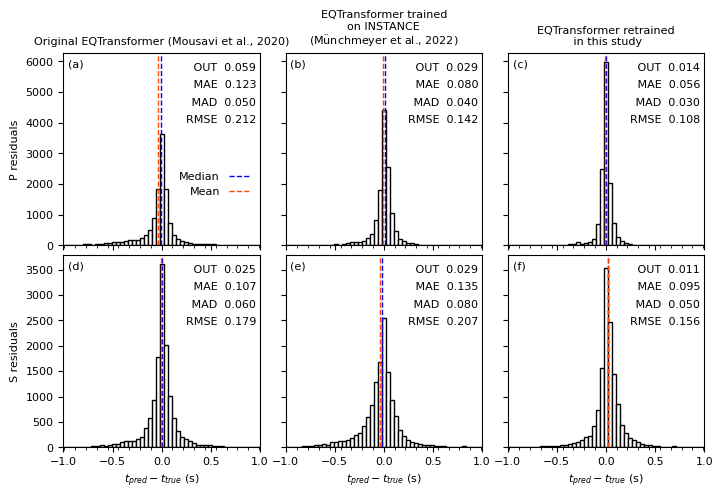

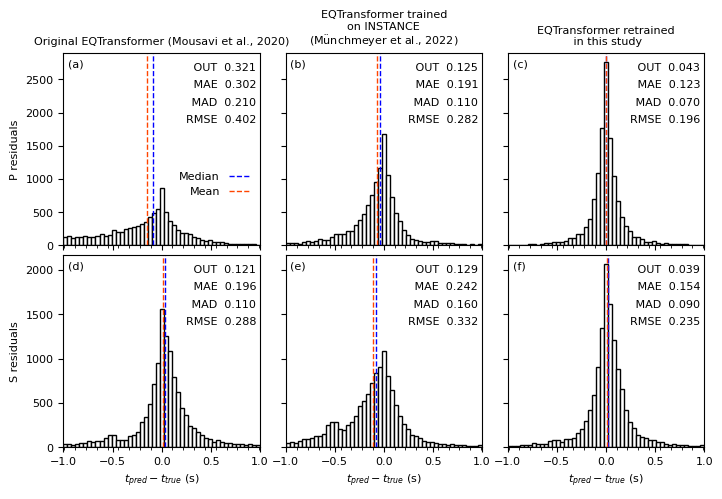

In [18]:
labels = {
    # "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
colors = {
    "org_pn": "mediumaquamarine",
    # "org_eqt": "darkslategrey",
    "org_eqt_nonconservative": "darkslategrey",
    "int_pn": "dodgerblue",
    "int_eqt": "darkblue",
    "vol_pn": "#F06292",
    "vol_eqt": "purple",
}
cm = 1 / 2.54
fts = 8
figsize = (21 * cm, 13 * cm)
fig1, axs1 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.05, wspace=0.13)
fig2, axs2 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
# thre_dict = {"p": p_thre_dict, "s": s_thre_dict}
axs_list = [axs1, axs2]
plt.subplots_adjust(hspace=0.05, wspace=0.13)
labels = {
    # "org_eqt": "Original EQTransformer\n(Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained\non INSTANCE\n"
    + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained\n in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained\non INSTANCE\n" + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained\n in this study",
}
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]


for j, data_type in enumerate(data_types_plotted):
    axs = axs_list[j]
    for i, model_name in enumerate(eqt_pred_dirs):
        task3_pred = pd.read_csv(
            pred_dir_path / data_type / "task123" / model_name / "test_task23.csv"
        )
        for k, phase in enumerate(["P", "S"]):
            ax = axs[k][i]
            pred_phase = task3_pred[task3_pred["phase_label"] == phase]
            pred_col = f"{phase.lower()}_sample_pred"
            diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase[
                "sampling_rate"
            ]
            bound = 1

            bins = np.linspace(-bound, bound, 50)
            ax.hist(
                diff,
                bins=bins,
                color="white",
                edgecolor="black",
            )
            outlier = diff[(diff < -bound) | (diff > bound)].copy()
            out = outlier.size / diff.size

            inwindow_residuals = diff.copy()
            inwindow_residuals = inwindow_residuals[
                (inwindow_residuals > -bound) & (inwindow_residuals < bound)
            ]
            mean2 = np.mean(inwindow_residuals)
            median2 = np.median(inwindow_residuals)
            std2 = np.std(inwindow_residuals, ddof=1)
            rmse2 = np.sqrt(np.mean(inwindow_residuals**2))
            mae2 = np.mean(np.abs(inwindow_residuals))

            mad2 = np.median(np.abs(inwindow_residuals - np.median(inwindow_residuals)))
            ax.axvline(x=median2, ls="--", linewidth=1, color="blue", label="Median")
            ax.axvline(x=mean2, ls="--", linewidth=1, color="orangered", label="Mean")

            text_y = 0.95
            for stat_name, stat in {
                "OUT": out,
                "MAE": mae2,
                "MAD": mad2,
                "RMSE": rmse2,
            }.items():
                ax.text(
                    0.98,
                    text_y,
                    f"""{stat_name:>6}{stat:>7.3f}""",
                    verticalalignment="top",
                    horizontalalignment="right",
                    transform=ax.transAxes,
                    fontsize=fts,
                )
                text_y -= 0.09
            ax.set_xlim([-bound, bound])
            ax.tick_params(labelsize=fts)
            if k == 0:
                # ax.set_ylabel(labels[model_name], fontsize=fts)
                ax.set_title(labels[model_name], fontsize=fts)

    axs[-1][0].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][1].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][2].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.11))

    # axs[0][0].set_title("P residuals", fontsize=fts)
    # axs[0][1].set_title("S residuals", fontsize=fts)
    axs[0][0].set_ylabel("P residuals", fontsize=fts)
    axs[1][0].set_ylabel("S residuals", fontsize=fts)
    for i_ax, ax in enumerate(axs.flat):
        ax.text(
            0.025,
            0.97,
            "(" + chr(97 + i_ax) + ")",
            verticalalignment="top",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            # color="black",
        )
    axs[0][0].legend(
        markerfirst=False,
        handlelength=1.9,
        #   markerscale=2,
        loc="lower right",
        bbox_to_anchor=(0.5, 0.2, 0.5, 0.3),
        frameon=False,
        fontsize=fts,
        # ncols=2,
    )
# fig1.savefig("task3_residuals_eqt_VT.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
# fig2.savefig("task3_residuals_eqt_LP.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

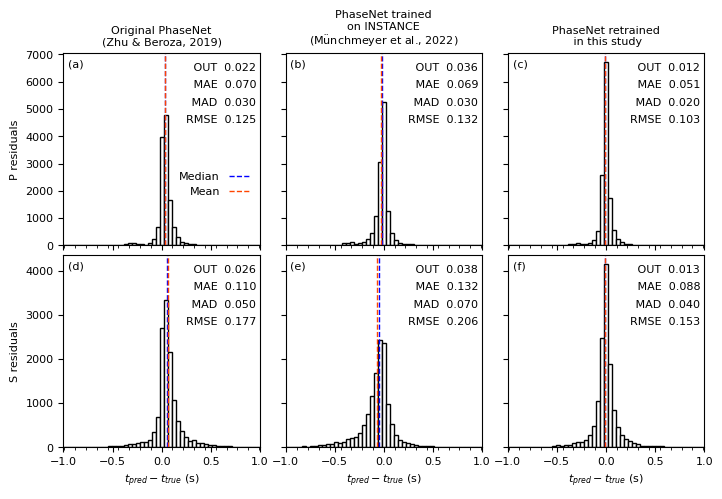

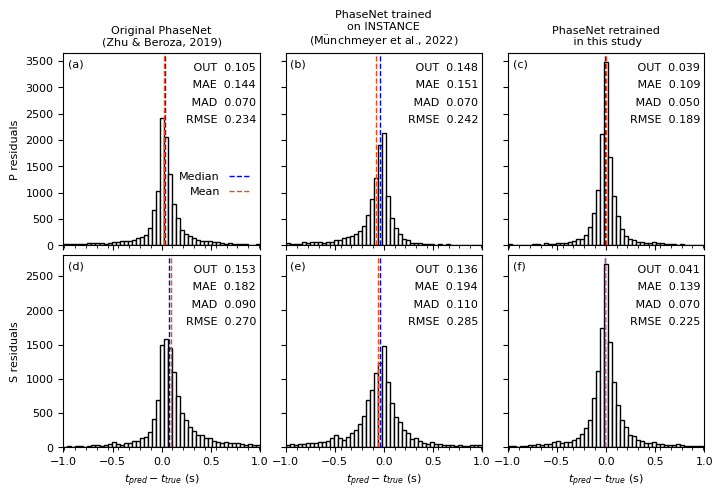

In [19]:
labels = {
    # "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
colors = {
    "org_pn": "mediumaquamarine",
    # "org_eqt": "darkslategrey",
    "org_eqt_nonconservative": "darkslategrey",
    "int_pn": "dodgerblue",
    "int_eqt": "darkblue",
    "vol_pn": "#F06292",
    "vol_eqt": "purple",
}
cm = 1 / 2.54
fts = 8
figsize = (21 * cm, 13 * cm)
fig1, axs1 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.05, wspace=0.13)
fig2, axs2 = plt.subplots(
    2, 3, figsize=figsize, sharex="all", sharey="row"
)  # ,layout="constrained"
# thre_dict = {"p": p_thre_dict, "s": s_thre_dict}
axs_list = [axs1, axs2]
plt.subplots_adjust(hspace=0.05, wspace=0.13)
labels = {
    # "org_eqt": "Original EQTransformer\n(Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained\non INSTANCE\n"
    + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained\n in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained\non INSTANCE\n" + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained\n in this study",
}
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]


for j, data_type in enumerate(data_types_plotted):
    axs = axs_list[j]
    for i, model_name in enumerate(pn_pred_dirs):
        task3_pred = pd.read_csv(
            pred_dir_path / data_type / "task123" / model_name / "test_task23.csv"
        )
        for k, phase in enumerate(["P", "S"]):
            ax = axs[k][i]
            pred_phase = task3_pred[task3_pred["phase_label"] == phase]
            pred_col = f"{phase.lower()}_sample_pred"
            diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase[
                "sampling_rate"
            ]
            bound = 1

            bins = np.linspace(-bound, bound, 50)
            ax.hist(
                diff,
                bins=bins,
                color="white",
                edgecolor="black",
            )
            outlier = diff[(diff < -bound) | (diff > bound)].copy()
            out = outlier.size / diff.size

            inwindow_residuals = diff.copy()
            inwindow_residuals = inwindow_residuals[
                (inwindow_residuals > -bound) & (inwindow_residuals < bound)
            ]
            mean2 = np.mean(inwindow_residuals)
            median2 = np.median(inwindow_residuals)
            std2 = np.std(inwindow_residuals, ddof=1)
            rmse2 = np.sqrt(np.mean(inwindow_residuals**2))
            mae2 = np.mean(np.abs(inwindow_residuals))

            mad2 = np.median(np.abs(inwindow_residuals - np.median(inwindow_residuals)))
            ax.axvline(x=median2, ls="--", linewidth=1, color="blue", label="Median")
            ax.axvline(x=mean2, ls="--", linewidth=1, color="orangered", label="Mean")

            text_y = 0.95
            for stat_name, stat in {
                "OUT": out,
                "MAE": mae2,
                "MAD": mad2,
                "RMSE": rmse2,
            }.items():
                ax.text(
                    0.98,
                    text_y,
                    f"""{stat_name:>6}{stat:>7.3f}""",
                    verticalalignment="top",
                    horizontalalignment="right",
                    transform=ax.transAxes,
                    fontsize=fts,
                )
                text_y -= 0.09
            ax.set_xlim([-bound, bound])
            ax.tick_params(labelsize=fts)
            if k == 0:
                # ax.set_ylabel(labels[model_name], fontsize=fts)
                ax.set_title(labels[model_name], fontsize=fts)

    axs[-1][0].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][1].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    axs[-1][2].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.11))

    # axs[0][0].set_title("P residuals", fontsize=fts)
    # axs[0][1].set_title("S residuals", fontsize=fts)
    axs[0][0].set_ylabel("P residuals", fontsize=fts)
    axs[1][0].set_ylabel("S residuals", fontsize=fts)
    for i_ax, ax in enumerate(axs.flat):
        ax.text(
            0.025,
            0.97,
            "(" + chr(97 + i_ax) + ")",
            verticalalignment="top",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            # color="black",
        )
    axs[0][0].legend(
        markerfirst=False,
        handlelength=1.9,
        #   markerscale=2,
        loc="lower right",
        bbox_to_anchor=(0.5, 0.2, 0.5, 0.3),
        frameon=False,
        fontsize=fts,
        # ncols=2,
    )
# fig1.savefig("task3_residuals_pn_VT.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
# fig2.savefig("task3_residuals_pn_LP.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

In [20]:
eqt_pred_dirs + pn_pred_dirs

('org_eqt_nonconservative', 'int_eqt', 'vol_eqt', 'org_pn', 'int_pn', 'vol_pn')

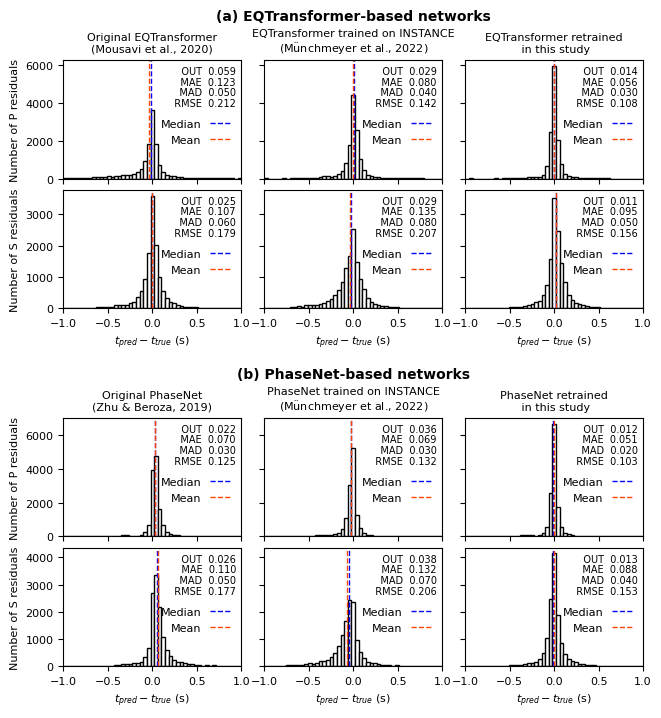

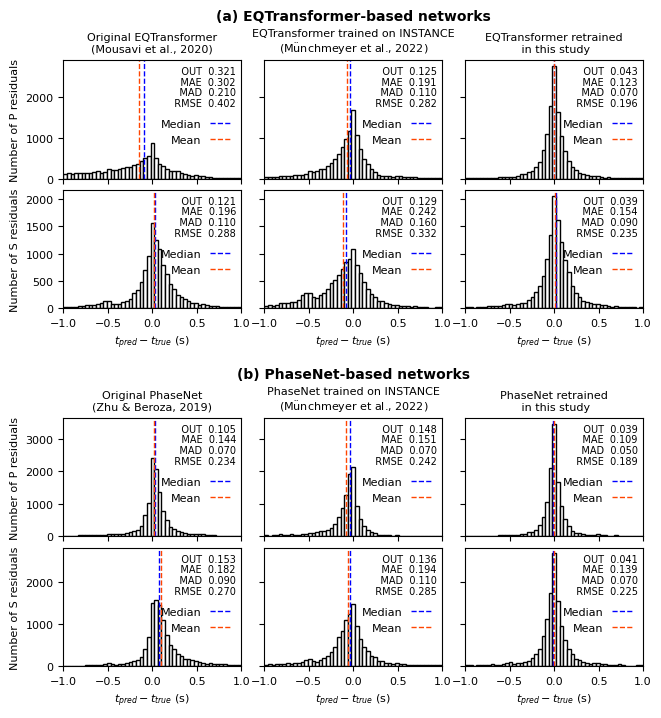

In [22]:
labels = {
    # "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
colors = {
    "org_pn": "mediumaquamarine",
    # "org_eqt": "darkslategrey",
    "org_eqt_nonconservative": "darkslategrey",
    "int_pn": "dodgerblue",
    "int_eqt": "darkblue",
    "vol_pn": "#F06292",
    "vol_eqt": "purple",
}
cm = 1 / 2.54
fts = 8
figsize = (19 * cm, 20.0 * cm)
fig1, axs1 = plt.subplots(
    5, 3, figsize=figsize, sharex="all", sharey="row", height_ratios=[3, 3, 2.2, 3, 3]
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.1, wspace=0.13)
fig2, axs2 = plt.subplots(
    5, 3, figsize=figsize, sharex="all", sharey="row", height_ratios=[3, 3, 2.2, 3, 3]
)  # ,layout="constrained"
# thre_dict = {"p": p_thre_dict, "s": s_thre_dict}
axs_list = [axs1, axs2]
plt.subplots_adjust(hspace=0.1, wspace=0.13)
labels = {
    # "org_eqt": "Original EQTransformer\n(Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer\n(Mousavi et al., 2020)",
    "int_eqt": "EQTransformer trained on INSTANCE\n"
    + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained\n in this study",
    "org_pn": "Original PhaseNet\n(Zhu & Beroza, 2019)",
    "int_pn": "PhaseNet trained on INSTANCE\n" + r"(M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained\n in this study",
}
data_types_plotted = ["rg_and_noise_pred", "lp_and_noise_pred"]


for j, data_type in enumerate(data_types_plotted):
    axs = axs_list[j]
    for i2, output_pred_dirs in enumerate([eqt_pred_dirs, pn_pred_dirs]):
        for i, model_name in enumerate(output_pred_dirs):
            task3_pred = pd.read_csv(
                pred_dir_path / data_type / "task123" / model_name / "test_task23.csv"
            )
            for k, phase in enumerate(["P", "S"]):
                ax = axs[k + i2 * 3][i]
                pred_phase = task3_pred[task3_pred["phase_label"] == phase]
                pred_col = f"{phase.lower()}_sample_pred"
                diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase[
                    "sampling_rate"
                ]
                bound = 1

                bins = np.linspace(-bound, bound, 50)
                ax.hist(
                    diff,
                    bins=bins,
                    color="white",
                    edgecolor="black",
                )
                outlier = diff[(diff < -bound) | (diff > bound)].copy()
                out = outlier.size / diff.size

                inwindow_residuals = diff.copy()
                inwindow_residuals = inwindow_residuals[
                    (inwindow_residuals > -bound) & (inwindow_residuals < bound)
                ]
                mean2 = np.mean(inwindow_residuals)
                median2 = np.median(inwindow_residuals)
                std2 = np.std(inwindow_residuals, ddof=1)
                rmse2 = np.sqrt(np.mean(inwindow_residuals**2))
                mae2 = np.mean(np.abs(inwindow_residuals))

                mad2 = np.median(
                    np.abs(inwindow_residuals - np.median(inwindow_residuals))
                )
                ax.axvline(
                    x=median2, ls="--", linewidth=1, color="blue", label="Median"
                )
                ax.axvline(
                    x=mean2, ls="--", linewidth=1, color="orangered", label="Mean"
                )

                text_y = 0.95
                for stat_name, stat in {
                    "OUT": out,
                    "MAE": mae2,
                    "MAD": mad2,
                    "RMSE": rmse2,
                }.items():
                    ax.text(
                        0.97,
                        text_y,
                        f"""{stat_name:>6}{stat:>7.3f}""",
                        verticalalignment="top",
                        horizontalalignment="right",
                        transform=ax.transAxes,
                        fontsize=fts - 1,
                    )
                    text_y -= 0.09
                ax.set_xlim([-bound, bound])
                ax.tick_params(labelsize=fts)
                if k == 0:
                    # ax.set_ylabel(labels[model_name], fontsize=fts)
                    ax.set_title(labels[model_name], fontsize=fts)
                ax.legend(
                    markerfirst=False,
                    handlelength=1.9,
                    #   markerscale=2,
                    loc="lower right",
                    bbox_to_anchor=(0.5, 0.2, 0.5, 0.3),
                    frameon=False,
                    fontsize=fts,
                    # ncols=2,
                )
    for i in range(3):
        axs[1][i].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
        axs[-1][i].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
        axs[1][i].xaxis.set_tick_params(which="both", labelbottom=True)
        # axs[-1][1].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
        # axs[-1][2].set_xlabel(r"$t_{pred}-t_{true}$ (s)", fontsize=fts)
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    # axs[0][0].set_title("P residuals", fontsize=fts)
    # axs[0][1].set_title("S residuals", fontsize=fts)
    axs[0][0].set_ylabel("Number of P residuals", fontsize=fts)
    axs[1][0].set_ylabel("Number of S residuals", fontsize=fts)
    axs[3][0].set_ylabel("Number of P residuals", fontsize=fts)
    axs[4][0].set_ylabel("Number of S residuals", fontsize=fts)

    axs[0][1].text(
        0.5,
        1.43,
        "(a) EQTransformer-based networks",
        verticalalignment="top",
        horizontalalignment="center",
        transform=axs[0][1].transAxes,
        fontsize=fts + 2,
        weight="bold",
        # color="black",
    )
    axs[3][1].text(
        0.5,
        1.43,
        "(b) PhaseNet-based networks",
        verticalalignment="top",
        horizontalalignment="center",
        transform=axs[3][1].transAxes,
        fontsize=fts + 2,
        weight="bold",
        # color="black",
    )
    axs[2][0].remove()
    axs[2][1].remove()
    axs[2][2].remove()

fig1.savefig(
    "task3_residuals_eqt_pn_VT.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
fig2.savefig(
    "task3_residuals_eqt_pn_LP.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)

# Plot F1 scores across different regions

In [39]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [40]:
print(vol_eqt.default_args["S_threshold"])
print(vol_pn.default_args["S_threshold"])

0.22
0.34


In [41]:
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.01,
    "org_eqt_nonconservative": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
    "std_eqt": 0.02,
    "std_pn": 0.01,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.001,
    "org_eqt_nonconservative": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
    "std_eqt": 0.01,
    "std_pn": 0.04,
}
print(p_thre_dict)
print(s_thre_dict)

{'vol_eqt': 0.22, 'vol_pn': 0.39, 'org_eqt': 0.01, 'org_eqt_nonconservative': 0.26, 'org_pn': 0.25, 'int_eqt': 0.04, 'int_pn': 0.13, 'std_eqt': 0.02, 'std_pn': 0.01}
{'vol_eqt': 0.22, 'vol_pn': 0.34, 'org_eqt': 0.001, 'org_eqt_nonconservative': 0.15, 'org_pn': 0.19, 'int_eqt': 0.04, 'int_pn': 0.05, 'std_eqt': 0.01, 'std_pn': 0.04}


In [42]:
# pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
pred_dirs = [
    "org_pn",
    "org_eqt_nonconservative",
    "int_pn",
    "int_eqt",
    "vol_pn",
    "vol_eqt",
]
pred_dir_path_list = [
    Path("/home/zhongyiyuan/volpick/model_training/Test/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_westernus/"),
    # Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/"),
    # Path("/home/zhongyiyuan/volpick/model_training/Test_cascade/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/"),
]

metrics_list = []
for i, pred_dir_path in enumerate(pred_dir_path_list):
    if i == 0:
        data_types_plotted = ["lp_and_noise_pred", "rg_and_noise_pred"]
    elif i == 1:
        data_types_plotted = [
            "westernus_lp_pred",
            "westernus_vt_pred",
        ]
    # elif i == 2:
    #     data_types_plotted = ["cascade_lp_pred", "cascade_vt_pred"]
    else:
        data_types_plotted = ["japan_tec_lp_pred"]

    precision_dict = [
        {x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))
    ]
    recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
    f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

    for model_name in pred_dirs:
        for j, data_type in enumerate(data_types_plotted):
            pred_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
            )
            p_row = pred_df[
                np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])
            ].iloc[0]
            s_row = pred_df[
                np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])
            ].iloc[0]
            assert (
                np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
            ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
            assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

            precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
            recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
            f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]
    metrics = {
        "Recall": recall_dict,
        "Precision": precision_dict,
        "F1 score": f1score_dict,
    }
    metrics_list.append(metrics)

F1 score

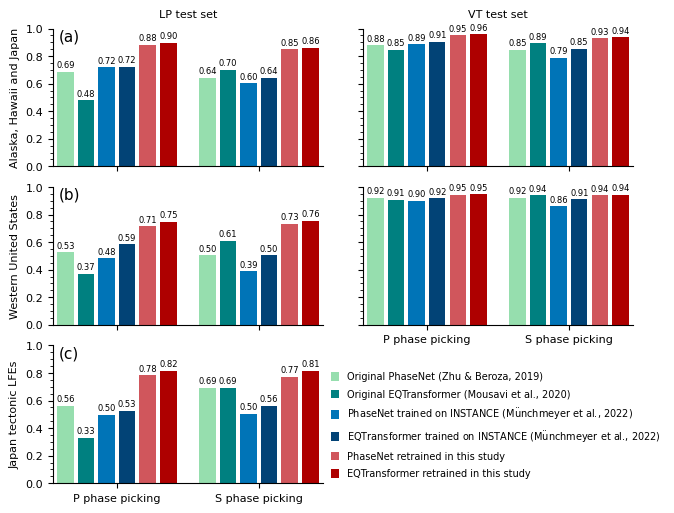

In [67]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
# labels = {
#     "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
#     "int_eqt": "EQTransformer trained on INSTANCE\n"
#     r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_eqt": "EQTransformer retrained in this study",
#     "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
#     "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_pn": "PhaseNet retrained in this study",
# }
labels = {
    # "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"  # 注意，这里的舍入用的是四舍六入五化偶
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[2][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.15, -1.18, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
# axs[1][1].set_xticks(x + 2.5 * interval, data_types, fontsize=fts)

axs[0][1].set_title("VT test set", y=1.02, fontsize=fts)
axs[0][0].set_title("LP test set", y=1.02, fontsize=fts)
plt.savefig("f1_scores_3_testsets.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
plt.savefig("f1_scores_3_testsets.jpg", dpi=600, bbox_inches="tight", pad_inches=0)

F1 score (for poster or presentation)

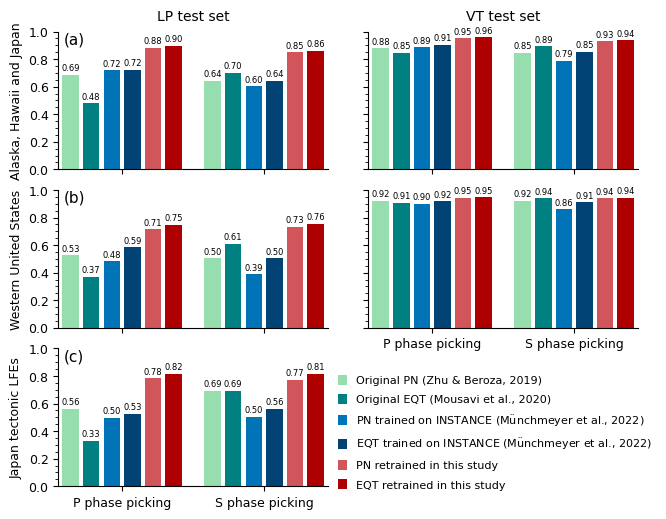

In [69]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
# labels = {
#     "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
#     "int_eqt": "EQTransformer trained on INSTANCE\n"
#     r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_eqt": "EQTransformer retrained in this study",
#     "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
#     "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_pn": "PhaseNet retrained in this study",
# }
labels = {
    # "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQT (Mousavi et al., 2020)",
    "int_eqt": r"EQT trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQT retrained in this study",
    "org_pn": "Original PN (Zhu & Beroza, 2019)",
    "int_pn": r"PN trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PN retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"  # 注意，这里的舍入用的是四舍六入五化偶
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts + 1)
        ax.tick_params(labelsize=fts + 1)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts+1)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts + 1)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.15, -1.25, 1, 1.5),
    frameon=False,
    fontsize=fts,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
# axs[1][1].set_xticks(x + 2.5 * interval, data_types, fontsize=fts)

axs[0][1].set_title("VT test set", y=1.02, fontsize=fts + 2)
axs[0][0].set_title("LP test set", y=1.02, fontsize=fts + 2)
plt.savefig(
    "f1_scores_3_testsets_presentation.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    "f1_scores_3_testsets_presentation.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)

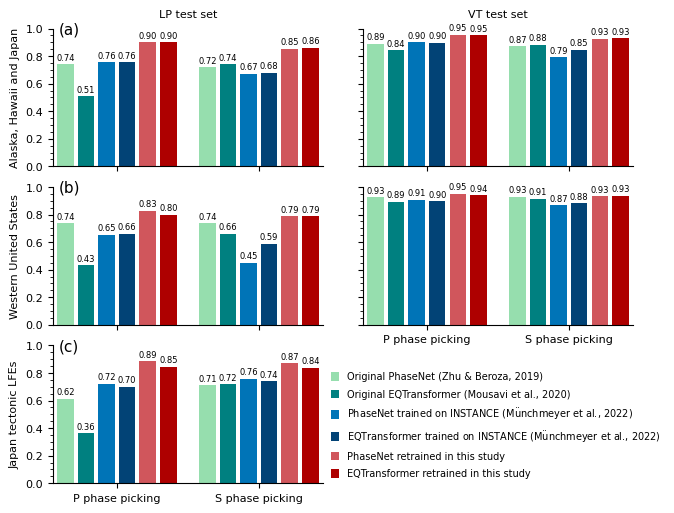

In [72]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["Precision"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.05,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[2][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.15, -1.18, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)
axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
axs[0][1].set_title("VT test set", y=1.02, fontsize=fts)
axs[0][0].set_title("LP test set", y=1.02, fontsize=fts)
plt.savefig("precision_3_testsets.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
plt.savefig("precision_3_testsets.jpg", dpi=600, bbox_inches="tight", pad_inches=0)

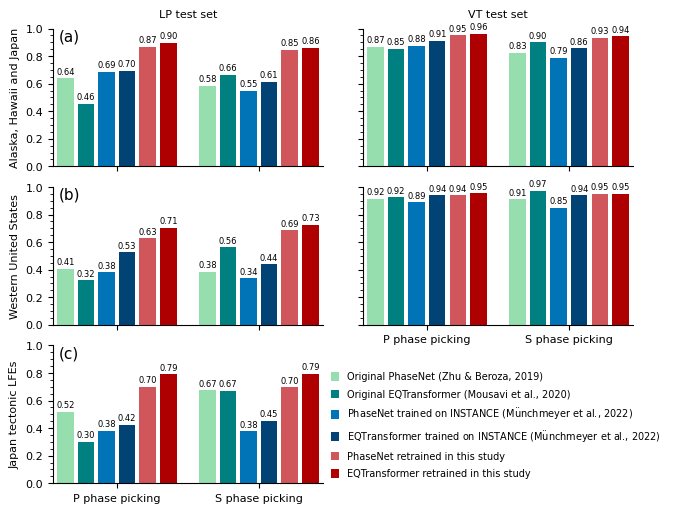

In [74]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["Recall"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]
fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.15, -1.18, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
axs[0][1].set_title("VT test set", y=1.02, fontsize=fts)
axs[0][0].set_title("LP test set", y=1.02, fontsize=fts)
plt.savefig("recall_3_testsets.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
plt.savefig("recall_3_testsets.jpg", dpi=600, bbox_inches="tight", pad_inches=0)

In [82]:
2 / (1 / 0.79 + 1 / 0.73)

0.7588157894736842

Plot F1 scores for models including STEAD

In [33]:
pred_dirs = [
    "org_pn",
    # "org_eqt",
    "org_eqt_nonconservative",
    "std_pn",
    "std_eqt",
    "int_pn",
    "int_eqt",
    "vol_pn",
    "vol_eqt",
]
pred_dir_path_list = [
    Path("/home/zhongyiyuan/volpick/model_training/Test/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp/"),
]

metrics_list = []
for i, pred_dir_path in enumerate(pred_dir_path_list):
    if i == 0:
        data_types_plotted = ["lp_and_noise_pred", "rg_and_noise_pred"]
    elif i == 1:
        data_types_plotted = [
            "ncedc_lp_pred",
            "ncedc_vt_pred",
        ]
    else:
        data_types_plotted = ["japan_tec_lp_pred"]

    precision_dict = [
        {x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))
    ]
    recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
    f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

    for model_name in pred_dirs:
        for j, data_type in enumerate(data_types_plotted):
            pred_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
            )
            p_row = pred_df[
                np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])
            ].iloc[0]
            s_row = pred_df[
                np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])
            ].iloc[0]
            assert (
                np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
            ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
            assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

            precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
            recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
            f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]
    metrics = {
        "Recall": recall_dict,
        "Precision": precision_dict,
        "F1 score": f1score_dict,
    }
    metrics_list.append(metrics)

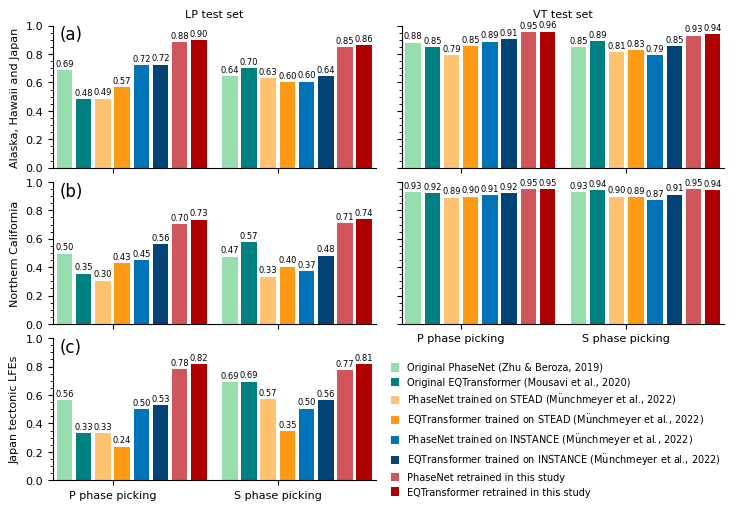

In [34]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.1, wspace=0.08)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.78
# x=np.array([0,1.5,3])
width = 0.26  # the width of the bars

metric_names = ["F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = [
    "#96DEAE",
    "#008080",
    "#FFC270",
    "#FF9A14",
    "#0074B7",
    "#024376",
    "#D0565C",
    "#AE0000",
]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
# labels = {
#     "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
#     "int_eqt": "EQTransformer trained on INSTANCE\n"
#     r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_eqt": "EQTransformer retrained in this study",
#     "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
#     "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_pn": "PhaseNet retrained in this study",
# }
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "std_eqt": r"EQTransformer trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "std_pn": r"PhaseNet trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Northern California",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"  # 注意，这里的舍入用的是四舍六入五化偶
        interval = width + 0.063
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 7.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 4,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.06, -1.28, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    # labelspacing=0.5,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
# axs[1][1].set_xticks(x + 2.5 * interval, data_types, fontsize=fts)

axs[0][1].set_title("VT test set", fontsize=fts)
axs[0][0].set_title("LP test set", fontsize=fts)
plt.savefig(
    "f1_scores_3_testsets_with_stead.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)

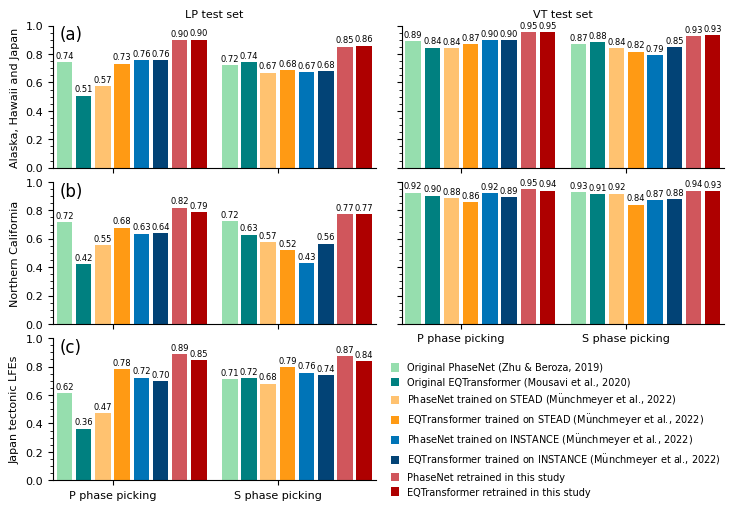

In [35]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.1, wspace=0.08)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.78
# x=np.array([0,1.5,3])
width = 0.26  # the width of the bars

metric_names = ["Precision"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = [
    "#96DEAE",
    "#008080",
    "#FFC270",
    "#FF9A14",
    "#0074B7",
    "#024376",
    "#D0565C",
    "#AE0000",
]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
# labels = {
#     "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
#     "int_eqt": "EQTransformer trained on INSTANCE\n"
#     r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_eqt": "EQTransformer retrained in this study",
#     "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
#     "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_pn": "PhaseNet retrained in this study",
# }
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "std_eqt": r"EQTransformer trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "std_pn": r"PhaseNet trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Northern California",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"  # 注意，这里的舍入用的是四舍六入五化偶
        interval = width + 0.063
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 7.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 4,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.06, -1.28, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    # labelspacing=0.5,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
# axs[1][1].set_xticks(x + 2.5 * interval, data_types, fontsize=fts)

axs[0][1].set_title("VT test set", fontsize=fts)
axs[0][0].set_title("LP test set", fontsize=fts)
plt.savefig(
    "precision_3_testsets_with_stead.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)

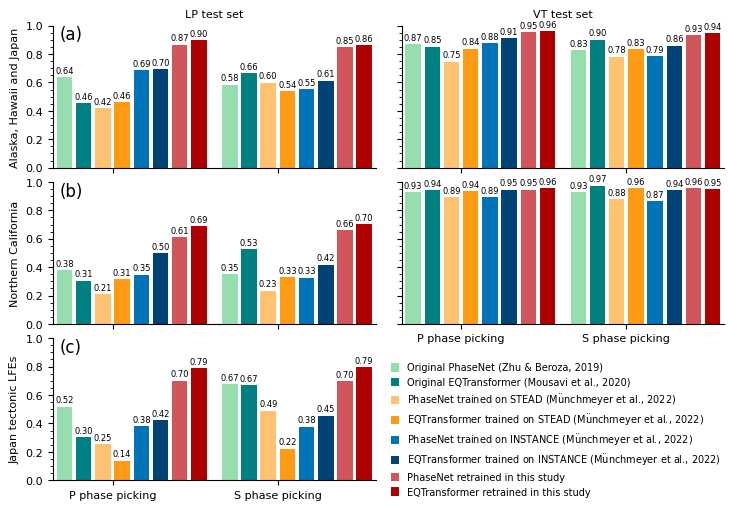

In [36]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(22 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.1, wspace=0.08)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.78
# x=np.array([0,1.5,3])
width = 0.26  # the width of the bars

metric_names = ["Recall"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = [
    "#96DEAE",
    "#008080",
    "#FFC270",
    "#FF9A14",
    "#0074B7",
    "#024376",
    "#D0565C",
    "#AE0000",
]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
# labels = {
#     "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
#     "int_eqt": "EQTransformer trained on INSTANCE\n"
#     r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_eqt": "EQTransformer retrained in this study",
#     "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
#     "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_pn": "PhaseNet retrained in this study",
# }
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "std_eqt": r"EQTransformer trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "std_pn": r"PhaseNet trained on STEAD (M$\rm{\"u}$nchmeyer et al., 2022)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Northern California",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"  # 注意，这里的舍入用的是四舍六入五化偶
        interval = width + 0.063
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 7.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 4,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.06, -1.28, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    # labelspacing=0.5,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
# axs[1][1].set_xticks(x + 2.5 * interval, data_types, fontsize=fts)

axs[0][1].set_title("VT test set", fontsize=fts)
axs[0][0].set_title("LP test set", fontsize=fts)
plt.savefig(
    "recall_3_testsets_with_stead.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)

# How to use the AR picker (there is an upstream bug I couldn's solve https://github.com/obspy/obspy/issues/1801)

/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/obspy/io/gse2/libgse2.py:319: UserWarning: Checksum differs only in absolute value. If this file was written with ObsPy GSE2, this is due to a bug in the obspy.io.gse2.write routine (resolved with [3431]), and thus this message can be safely ignored.
  warnings.warn(msg, UserWarning)


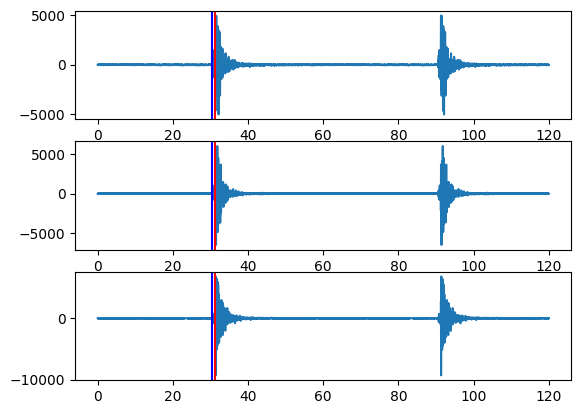

In [ ]:
tr1 = read("https://examples.obspy.org/loc_RJOB20050801145719850.z.gse2")[0]
tr2 = read("https://examples.obspy.org/loc_RJOB20050801145719850.n.gse2")[0]
tr3 = read("https://examples.obspy.org/loc_RJOB20050801145719850.e.gse2")[0]
tr1.data = np.append(tr1.data, tr1.data)
tr2.data = np.append(tr2.data, tr2.data)
tr3.data = np.append(tr3.data, tr3.data)
sampling_rage = tr1.stats.sampling_rate
p_pick, s_pick = ar_pick(
    tr1.data,
    tr2.data,
    tr3.data,
    sampling_rage,
    f1=1.0,
    f2=20.0,
    lta_p=1.0,
    sta_p=0.2,
    lta_s=4.0,
    sta_s=1.0,
    m_p=2,
    m_s=8,
    l_p=0.5,
    l_s=0.25,
)
fig, axs = plt.subplots(3, 1)
st = Stream([tr1, tr2, tr3])
for i in range(3):
    axs[i].plot(st[i].times(), st[i].data)
    axs[i].axvline(p_pick, color="blue")
    axs[i].axvline(s_pick, color="red")

In [197]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")
dataset_dev = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset_dev.filter(dataset_dev["split"].isin(["dev"]), inplace=True)
dataset_dev.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 17744/17744 [00:02<00:00, 6337.43it/s]


In [198]:
eval_set = "dev"
targets_path = Path("/home/zhongyiyuan/volpick/model_training/Eval_targets/all")

dev_test_set = dataset_dev
split = dev_test_set.get_split(eval_set)
print(f"Starting set: {eval_set}")
split.preload_waveforms(pbar=True)

# steered metatdata
task_csv = targets_path / "task0.csv"
task_targets = pd.read_csv(task_csv)
task_targets = task_targets[task_targets["source_type"] != "noise"]
task_targets = task_targets[task_targets["trace_split"] == eval_set]

generator = sbg.SteeredGenerator(split, task_targets)
print(len(generator))
# windowlen = {"PhaseNet": 3001, "EQTransformer": 6000, "VolEQTransformer": 6000}
windowlen = {"PhaseNet": 3001, "EQTransformer": 6000}
generator.add_augmentations(
    [
        sbg.SteeredWindow(windowlen=windowlen["EQTransformer"], strategy="pad"),
        sbg.ChangeDtype(np.float32),
        sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    ]
)

Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 337947.13it/s]

15190


# PK BAER picker

In [6]:
class BaerKradolfer:
    def __init__(self, lp, hp, tdownmax, tupevent, thr1, windowlen=3000):
        self.lp = lp
        self.hp = hp
        self.tdownmax = tdownmax
        self.tupevent = tupevent
        self.thr1 = thr1
        self.windowlen = windowlen

    def get_augmentations(self):
        return [
            sbg.SteeredWindow(windowlen=self.windowlen, strategy="pad"),
            sbg.ChangeDtype(np.float32),
            sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
        ]

    def predict(self, sample):
        pred_relative_to_p0 = -1

        x = sample[f"X"][0]  # Remove channel axis
        p0, p1 = sample[f"window_borders"]
        p_pick, _ = pk_baer(
            x,
            100,
            int(100 * self.tdownmax),
            int(100 * self.tupevent),
            self.thr1,
            2 * self.thr1,
            100,
            100,
        )
        pred_relative_to_p0 = p_pick - p0

        return pred_relative_to_p0

    @classmethod
    def load_from_log(cls, path):
        opt = -np.inf
        params = {}
        with open(path, "r") as f:
            for line in f:
                if not line.strip():
                    pass
                parsed_line = json.loads(line)
                if parsed_line["target"] > opt:
                    opt = parsed_line["target"]
                    params = parsed_line["params"]

        logging.warning(f"Optimal value: {- opt:.1f}\tParams: {params}")
        return cls(**params)

In [3]:
limit = 2500
np.random.seed(42)

targets_path = Path("/home/zhongyiyuan/volpick/model_training/Eval_targets/all")

# steered metatdata
task_csv = targets_path / "task0.csv"
targets = pd.read_csv(task_csv)
targets = targets[targets["trace_split"] == "dev"]
targets = targets[pd.notna(targets["trace_p_arrival_sample"])]
targets = targets[targets["source_type"] != "noise"]

trace_names = None
if len(targets) > limit:
    trace_names = targets["trace_name"].values.copy()
    np.random.shuffle(trace_names)
    trace_names = trace_names[:limit]
    mask = targets["trace_name"].isin(set(trace_names))
    targets = targets[mask]

data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")
dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev"]), inplace=True)
if trace_names is not None:
    mask = dataset.metadata["trace_name"].isin(set(trace_names))
    dataset.filter(mask, inplace=True)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 2500/2500 [00:02<00:00, 1083.77it/s]


In [7]:
pbar = True
bounds = {
    "lp": (1, 49),
    "hp": (0.001, 5),
    "tdownmax": (0.5, 15),
    "tupevent": (0.3, 3),
    "thr1": (1, 40),
}

picker = BaerKradolfer(0, 0, 0, 0, 0)  # Parameters will anyhow be overwritten


def fitness(lp, hp, tdownmax, tupevent, thr1):
    """
    Fitness function for Bayesian optimization

    :param lp: Lowpass frequency
    :param hp: Highpass frequency
    :param tdownmax: See obspy.signal.trigger.pk_bear
    :param tupevent: See obspy.signal.trigger.pk_bear
    :param thr1: See obspy.signal.trigger.pk_bear . We also set thr2 = 2 * thr1
    :return:
    """
    picker.lp = lp
    picker.hp = hp
    picker.tdownmax = tdownmax
    picker.tupevent = tupevent
    picker.thr1 = thr1

    generator = sbg.SteeredGenerator(dataset, targets)
    generator.add_augmentations(picker.get_augmentations())

    preds = []
    if pbar:
        itr = tqdm(range(len(generator)), total=len(generator))
    else:
        itr = range(len(generator))

    for i in itr:
        pred_relative_to_p0 = picker.predict(generator[i])
        row = targets.iloc[i]

        pred = row["start_sample"] + pred_relative_to_p0
        preds.append(pred)

    preds = np.array(preds)
    rmse = np.sqrt(
        np.mean((preds - targets["trace_p_arrival_sample"].values) ** 2)
    )  # RMSE in samples

    return -rmse  # Negative as optimizer is built for maximizing the target function

In [11]:
optimizer = BayesianOptimization(
    f=fitness,
    pbounds=bounds,
    random_state=1,
)
# Setup loggers
os.makedirs("baer_logs", exist_ok=True)
logger = JSONLogger(path=f"baer_logs/{targets_path.name}.json")
screen_logger = ScreenLogger()
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.subscribe(Events.OPTIMIZATION_STEP, screen_logger)

# Roughly matching entries from NMSOP
optimizer.probe(
    params={"lp": 49, "hp": 3, "tdownmax": 2, "tupevent": 1.5, "thr1": 10},
    lazy=True,
)
optimizer.probe(
    params={"lp": 5, "hp": 1, "tdownmax": 3, "tupevent": 1.5, "thr1": 5}, lazy=True
)
optimizer.probe(
    params={"lp": 2, "hp": 0.1, "tdownmax": 5, "tupevent": 1.5, "thr1": 2},
    lazy=True,
)

optimizer.maximize(init_points=25, n_iter=500)

print(optimizer.max)

  0%|          | 0/2500 [00:00<?, ?it/s]

| 1         | -803.4    | 3.0       | 49.0      | 2.0       | 10.0      | 1.5       |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 2         | -1.134e+0 | 1.0       | 5.0       | 3.0       | 5.0       | 1.5       |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 3         | -1.315e+0 | 0.1       | 2.0       | 5.0       | 2.0       | 1.5       |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 4         | -841.6    | 2.086     | 35.58     | 0.5017    | 12.79     | 0.6962    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 5         | -880.2    | 0.4626    | 9.94      | 5.511     | 16.47     | 1.755     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 6         | -1.026e+0 | 2.097     | 33.89     | 3.465     | 35.25     | 0.3739    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 7         | -1.138e+0 | 3.353     | 21.03     | 8.601     | 6.475     | 0.8349    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 8         | -1.295e+0 | 4.004     | 47.48     | 5.045     | 28.0      | 2.666     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 9         | -949.4    | 4.473     | 5.082     | 1.066     | 7.623     | 2.671     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 10        | -1.05e+03 | 0.4926    | 21.21     | 14.39     | 21.79     | 2.168     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 11        | -1.336e+0 | 1.578     | 33.95     | 12.6      | 1.713     | 2.325     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 12        | -1.02e+03 | 4.944     | 36.91     | 4.566     | 31.78     | 0.5787    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 13        | -778.5    | 2.24      | 44.61     | 4.757     | 12.22     | 0.6511    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 14        | -831.5    | 0.09782   | 33.58     | 3.569     | 11.36     | 1.627     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 15        | -1.286e+0 | 0.2678    | 28.56     | 2.628     | 23.98     | 2.189     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 16        | -731.2    | 0.5126    | 20.87     | 10.57     | 17.15     | 0.4349    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 17        | -1.294e+0 | 2.68      | 32.86     | 7.966     | 37.84     | 1.884     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 18        | -1.294e+0 | 4.517     | 7.599     | 2.52      | 32.49     | 1.374     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 19        | -1.273e+0 | 0.8276    | 45.52     | 5.543     | 30.28     | 2.26      |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 20        | -803.0    | 4.417     | 30.94     | 11.39     | 14.61     | 1.029     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 21        | -1.124e+0 | 4.48      | 21.55     | 14.49     | 26.87     | 1.979     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 22        | -985.3    | 0.5746    | 46.58     | 7.024     | 23.56     | 1.402     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 23        | -1.351e+0 | 1.186     | 44.36     | 8.818     | 1.112     | 1.966     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 24        | -974.0    | 1.634     | 26.3      | 13.35     | 14.93     | 2.753     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 25        | -1.25e+03 | 3.117     | 1.759     | 13.98     | 27.94     | 2.993     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 26        | -885.7    | 0.8625    | 7.583     | 14.02     | 28.18     | 0.4782    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 27        | -932.4    | 3.778     | 37.19     | 13.88     | 28.75     | 0.6355    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 28        | -1.138e+0 | 0.1004    | 2.258     | 0.9104    | 10.6      | 2.622     |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 29        | -735.3    | 3.318     | 37.39     | 7.27      | 14.94     | 0.4796    |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 30        | -731.4    | 0.001     | 15.23     | 10.95     | 16.28     | 0.3       |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 31        | -703.8    | 5.0       | 17.18     | 7.502     | 17.11     | 0.3       |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 32        | -742.1    | 5.0       | 40.12     | 14.27     | 17.99     | 0.3       |


  0%|          | 0/2500 [00:00<?, ?it/s]

| 33        | -696.2    | 0.001     | 18.25     | 4.168     | 15.65     | 0.3       |


  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
fitness(**{"lp": 49, "hp": 3, "tdownmax": 2, "tupevent": 1.5, "thr1": 10})

  0%|          | 0/2500 [00:00<?, ?it/s]

-803.4137290338024

In [19]:
targets["start_sample"] + [1 for _ in range(len(targets))]

9        4582
24       3847
51       4490
53       5656
59       4121
         ... 
49917    2456
49990     623
49996    1025
50007    1641
50013    1594
Name: start_sample, Length: 2500, dtype: int64